In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin

In [53]:
class MixedCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=5):
        self.threshold = threshold
        self.one_hot_cols = []
        self.target_encoding_maps = {}

    def fit(self, X, y):
        self.target = y.name if hasattr(y, 'name') else 'target'
        for col in X.select_dtypes(include='object').columns:
            if X[col].nunique() < self.threshold:
                self.one_hot_cols.append(col)
            else:
                self.target_encoding_maps[col] = X[[col]].join(y).groupby(col)[self.target].mean().to_dict()
        return self

    def transform(self, X):
        X_new = X.copy()
        for col in self.one_hot_cols:
            dummies = pd.get_dummies(X_new[col], prefix=col, drop_first=True, dtype=int)
            X_new = X_new.drop(col, axis=1)
            X_new = pd.concat([X_new, dummies], axis=1)

        for col, mapping in self.target_encoding_maps.items():
            X_new[col] = X_new[col].map(mapping).fillna(0)

        return X_new

–ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞—Ç–∞—Å–µ—Ç

In [33]:
df = pd.read_excel('O:\–ü–ª–∞–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ\–ü–∞–ø–∫–∏ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤\–ö–æ–ª—á–∞–∫\Bi\–î–∞–Ω–Ω—ã–µ –¥–ª—è –í–ö–†.xlsx')

–í—ã–≤–µ–¥–µ–º –ø–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [7]:
df.head()

–ú–æ–¥–µ–ª—å –¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è –¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞ –¶–µ–ª–µ–≤–∞—è –≥—Ä—É–ø–ø–∞  \
0       BAC002021 –∑–µ–ª–µ–Ω—ã–π          ACT pants             ACT         B Kids   
1  BAC002044 —á–µ—Ä–Ω—ã–π/—Å–∏–Ω–∏–π          ACT pants             ACT         B Kids   
2       BAC002044 –∫—Ä–∞—Å–Ω—ã–π          ACT pants             ACT         B Kids   
3   BAC002109 —Ç–µ–º–Ω–æ-—Å–∏–Ω–∏–π          ACT pants             ACT         B Kids   
4  BAC002109 —Å–µ—Ä—ã–π –º–µ–ª–∞–Ω–∂          ACT pants             ACT         B Kids   

            –ê—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç  –ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ä–æ–≤  –°–µ–±–µ—Å—Ç–æ–∏–º–æ—Å—Ç—å  –¶–µ–Ω–∞ —Ä–æ–∑–Ω–∏—á–Ω–∞—è  \
0  –û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                6            144             499   
1  –û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                6            135             499   
2  –û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                6            135             499   
3  –û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                6            157             499   
4  –û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                6            202             499   

  –õ–∏–¥–µ—Ä—Å—Ç–≤–æ –ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ       IMU –∞—Ç—Ä–∏–±—É—Ç1 –∞—Ç—Ä–∏–±—É—Ç2 –∞—Ç—Ä–∏–±—É—Ç3  \
0     –õ–∏–¥–µ—Ä                  import  0.682565  comfort      NaN      NaN   
1     –õ–∏–¥–µ—Ä                  import  0.702405  comfort      NaN      NaN   
2     –õ–∏–¥–µ—Ä                  import  0.702405  comfort      NaN      NaN   
3     –õ–∏–¥–µ—Ä                  import  0.653908  comfort      NaN      NaN   
4     –õ–∏–¥–µ—Ä                  import  0.554709  comfort      NaN      NaN   

  –∞—Ç—Ä–∏–±—É—Ç4     –∞—Ç—Ä–∏–±—É—Ç5 –°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞ –°—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞     –¢–∏–ø —Ç–∫–∞–Ω–∏  \
0  240 gsm        print              USA           –ë–∞–Ω–≥–ª–∞–¥–µ—à  Terry-fleece   
1  200 gsm        print              USA               –ö–∏—Ç–∞–π  Terry-fleece   
2  200 gsm        print              USA               –ö–∏—Ç–∞–π  Terry-fleece   
3  240 gsm  no elements              USA               –ö–∏—Ç–∞–π  Terry-fleece   
4  240 gsm  no elements              USA               –ö–∏—Ç–∞–π  Terry-fleece   

           –¶–≤–µ—Ç –û–¥–Ω–æ—Ç–æ–Ω–Ω–æ—Å—Ç—å –≠–ª–µ–º–µ–Ω—Ç—ã –¥–∏–∑–∞–π–Ω–∞  –ü–æ—Å–∞–¥–∫–∞    –ú–æ–¥–Ω–æ—Å—Ç—å –ü–µ—Ä–µ–Ω–æ—Å  \
0         Green        Solid            print  comfort  Commercial     NaN   
1          Navy        Solid            print  comfort  Commercial     NaN   
2           Red        Solid            print  comfort  Commercial     NaN   
3          Navy        Solid      no elements  comfort  Commercial     NaN   
4  Grey Melange        Solid      no elements  comfort  Commercial     NaN   

  –¢–∏–ø –ø—Ä–æ–¥—É–∫—Ç–∞ –ö–æ–ª–ª–µ–∫—Ü–∏—è –ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã    –ü–æ–ª—É–≥–æ–¥–∏–µ    –ö–≤–∞—Ä—Ç–∞–ª   –ì–æ–¥  \
0       Jogger       BTS       Medium  2 half 2016  3 quarter  2016   
1       Jogger       BTS       Medium  2 half 2016  3 quarter  2016   
2       Jogger       BTS       Medium  2 half 2016  3 quarter  2016   
3       Jogger       BTS       Medium  2 half 2016  3 quarter  2016   
4       Jogger       BTS       Medium  2 half 2016  3 quarter  2016   

   –ù–ï–î–ï–õ–Ø PMM –ú–ï–°–Ø–¶ PMM  –ó–∞–∫–∞–∑  –ì–ª—É–±–∏–Ω–∞ –Ω–∞ –º–æ–¥–µ–ª—å  \
0          29      July   5000           2.465400   
1          29      July  10000           3.074141   
2          29      July   5000           2.567976   
3          32    August  10000           2.997602   
4          32    August  10000           3.008424   

   –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç —É—Å–ø–µ—à–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏ –ø—Ä–∏–∑–Ω–∞–∫ —É—Å–ø–µ—à–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏  
0                             39                        –¥–∞  
1                             77                        –¥–∞  
2                             39                        –¥–∞  
3                            186                        –¥–∞  
4                            133                     

–ü—Ä–æ–≤–µ—Ä–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π

In [38]:
df.isna().sum()

–ú–æ–¥–µ–ª—å                               0
–¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è                   0
–¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞                      0
–¶–µ–ª–µ–≤–∞—è –≥—Ä—É–ø–ø–∞                       0
–ê—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                          0
–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ä–æ–≤                      0
–°–µ–±–µ—Å—Ç–æ–∏–º–æ—Å—Ç—å                        0
–¶–µ–Ω–∞ —Ä–æ–∑–Ω–∏—á–Ω–∞—è                       0
–õ–∏–¥–µ—Ä—Å—Ç–≤–æ                            0
–ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ              0
IMU                                  0
–∞—Ç—Ä–∏–±—É—Ç1                           788
–∞—Ç—Ä–∏–±—É—Ç2                          4433
–∞—Ç—Ä–∏–±—É—Ç3                         10153
–∞—Ç—Ä–∏–±—É—Ç4                          4410
–∞—Ç—Ä–∏–±—É—Ç5                         14236
–°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞                  2679
–°—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞                  8
–¢–∏–ø —Ç–∫–∞–Ω–∏                         2205
–¶–≤–µ—Ç                                72
–û–¥–Ω–æ—

–ü–æ—Å—á–∏—Ç–∞–µ–º –¥–æ–ª—é –ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º—é: –≤–æ –≤—Å–µ–º –¥–∞—Ç–∞—Å–µ—Ç–µ –∏ –ø–æ –≥–æ–¥–∞–º

In [39]:
# –û–±—â–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
total_rows = len(df)
null_counts = df.isnull().sum()
null_share = null_counts / total_rows      # –¥–æ–ª—è
 
# –û–±—ä–µ–¥–∏–Ω—ë–Ω–Ω—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç
null_report = pd.DataFrame({
    'null_count': null_counts,
    'null_share': null_share
})
 
# –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –ø–æ —É–±—ã–≤–∞–Ω–∏—é –¥–æ–ª–∏ null (–Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ)
null_report = null_report[null_report['null_count'] > 0]  # —Å–æ—Ä—Ç–∏—Ä—É–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –±–æ–ª—å—à–µ 0
null_report = null_report.sort_values(by='null_share', ascending=False)
 
print(null_report)

                     null_count  null_share
–∞—Ç—Ä–∏–±—É—Ç5                  14236    0.189773
–ü–µ—Ä–µ–Ω–æ—Å                   13538    0.180468
–∞—Ç—Ä–∏–±—É—Ç3                  10153    0.135344
–ü–æ—Å–∞–¥–∫–∞                    8806    0.117388
–û–¥–Ω–æ—Ç–æ–Ω–Ω–æ—Å—Ç—å               8018    0.106884
–¢–∏–ø –ø—Ä–æ–¥—É–∫—Ç–∞               5018    0.066892
–∞—Ç—Ä–∏–±—É—Ç2                   4433    0.059094
–∞—Ç—Ä–∏–±—É—Ç4                   4410    0.058787
–≠–ª–µ–º–µ–Ω—Ç—ã –¥–∏–∑–∞–π–Ω–∞           3642    0.048550
–°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞           2679    0.035712
–¢–∏–ø —Ç–∫–∞–Ω–∏                  2205    0.029394
–ú–æ–¥–Ω–æ—Å—Ç—å                   1893    0.025235
–∞—Ç—Ä–∏–±—É—Ç1                    788    0.010504
–ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã                342    0.004559
–¶–≤–µ—Ç                         72    0.000960
–°—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞           8    0.000107


In [40]:
# –ü–æ–∫–∞–∑—ã–≤–∞—Ç—å –≤—Å–µ —Å—Ç—Ä–æ–∫–∏
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# –ì—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∞ –ø–æ '–ì–æ–¥' –∏ –ø–æ–¥—Å—á—ë—Ç null –∏ –¥–æ–ª–µ–π
result = []
 
for year, group in df.groupby('–ì–æ–¥'):
    total_rows = len(group)
    null_counts = group.isnull().sum()
    null_share = null_counts / total_rows
 
    report = pd.DataFrame({
        'year': year,
        'column': null_counts.index,
        'null_count': null_counts.values,
        'null_share': null_share.values
    })
 
    result.append(report)
 
# –û–±—ä–µ–¥–∏–Ω—è–µ–º –ø–æ –≤—Å–µ–º –≥–æ–¥–∞–º
final_report = pd.concat(result, ignore_index=True)
 
# –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ –∫–æ–ª–æ–Ω–∫–∞–º, –≥–¥–µ –¥–æ–ª—è –Ω–µ–∑–∞–ø–æ–ª–Ω–µ–Ω–Ω—ã—Ö –ø–æ–ª–µ–π –±–æ–ª–µ–µ 15%
final_report = final_report[final_report['null_share'] > 0.15]
 
# –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞
final_report = final_report.sort_values(['year', 'null_share'], ascending=[True, False])
 

print(final_report)

     year            column  null_count  null_share
24   2016           –ü–µ—Ä–µ–Ω–æ—Å        7694    0.909134
15   2016          –∞—Ç—Ä–∏–±—É—Ç5        2084    0.246248
13   2016          –∞—Ç—Ä–∏–±—É—Ç3        1324    0.156446
61   2017           –ü–µ—Ä–µ–Ω–æ—Å        5793    0.550718
52   2017          –∞—Ç—Ä–∏–±—É—Ç5        2590    0.246221
53   2017  –°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞        2246    0.213518
50   2017          –∞—Ç—Ä–∏–±—É—Ç3        1923    0.182812
89   2018          –∞—Ç—Ä–∏–±—É—Ç5        2749    0.289704
87   2018          –∞—Ç—Ä–∏–±—É—Ç3        1856    0.195595
126  2019          –∞—Ç—Ä–∏–±—É—Ç5        1859    0.237269
163  2020          –∞—Ç—Ä–∏–±—É—Ç5        1057    0.163774
200  2021          –∞—Ç—Ä–∏–±—É—Ç5        1280    0.167036


–£–¥–∞–ª–∏–º —Å—Ç–æ–ª–±—Ü—ã –ê—Ç—Ä–∏–±—É—Ç 5, –∞—Ç—Ä–∏–±—É—Ç 3 –∏ –ü–µ—Ä–µ–Ω–æ—Å –ø–æ—Å–∫–æ–ª—å–∫—É –Ω–∞–º –º–Ω–æ–≥–æ –ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π. –£–¥–∞–ª–∏–º –ø–æ–ª–µ –ú–æ–¥–µ–ª—å - –æ–Ω–æ —É–Ω–∏–∫–∞–ª—å–Ω–æ –∏ –ø–æ–ª—è –ø–æ–ª—É–≥–æ–¥–∏–µ –∏ –∫–≤–∞—Ä—Ç–∞–ª, –æ—Å—Ç–∞–≤–∏–º —Ç–æ–ª—å–∫–æ –≥–æ–¥ –∏ –Ω–µ–¥–µ–ª—é

In [34]:
df = df.drop(['–∞—Ç—Ä–∏–±—É—Ç5','–∞—Ç—Ä–∏–±—É—Ç3','–ü–µ—Ä–µ–Ω–æ—Å', '–ú–æ–¥–µ–ª—å','–ü–æ–ª—É–≥–æ–¥–∏–µ','–ö–≤–∞—Ä—Ç–∞–ª'],axis=1)

–í –æ—Å—Ç–∞–≤—à–∏—Ö—Å—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö –∑–∞–º–µ–Ω–∏–º 0 –∏ –ø—É—Å—Ç–æ—Ç—É –Ω–∞ n/a

In [35]:
for col in df.describe(include = 'object'):
    df[col]=df[col].fillna('n/a')
    df[col]=df[col].replace('0','n/a')

–û–ø—Ä–µ–¥–µ–ª–∏–º —Ç–∞—Ä–≥–µ—Ç

In [36]:
df.loc[(df['–õ–∏–¥–µ—Ä—Å—Ç–≤–æ'] == '–í—ã—à–µ –ø–ª–∞–Ω–∞') | (df['–õ–∏–¥–µ—Ä—Å—Ç–≤–æ'] == '–õ–∏–¥–µ—Ä') | (df['–õ–∏–¥–µ—Ä—Å—Ç–≤–æ'] == '–û—Å—Ç–∞–ª—å–Ω—ã–µ'),'target'] = 1
df.loc[(df['–õ–∏–¥–µ—Ä—Å—Ç–≤–æ'] == '–ù–∏–∂–µ –ø–ª–∞–Ω–∞') | (df['–õ–∏–¥–µ—Ä—Å—Ç–≤–æ'] == '–ê–Ω—Ç–∏-–ª–∏–¥–µ—Ä'),'target'] = 0

–£–¥–∞–ª–∏–º –ø–æ–ª—è, –∫–æ—Ç–æ—Ä—ã–µ –æ–¥–Ω–æ–∑–Ω–∞—á–Ω–æ —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ –ª–∏–¥–µ—Ä—Å—Ç–≤–æ

In [37]:
df = df.drop(['–ø—Ä–∏–∑–Ω–∞–∫ —É—Å–ø–µ—à–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏', '–õ–∏–¥–µ—Ä—Å—Ç–≤–æ', '–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç —É—Å–ø–µ—à–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏' ],axis=1)

–ü—Ä–æ–≤–µ—Ä–∏–º —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å —Ç–∞—Ä–≥–µ—Ç–∞

In [38]:
df['target'].value_counts()

target
0.0    43879
1.0    31137
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75016 entries, 0 to 75015
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   –¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è       75016 non-null  object 
 1   –¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞          75016 non-null  object 
 2   –¶–µ–ª–µ–≤–∞—è –≥—Ä—É–ø–ø–∞           75016 non-null  object 
 3   –ê—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç              75016 non-null  object 
 4   –ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ä–æ–≤          75016 non-null  int64  
 5   –°–µ–±–µ—Å—Ç–æ–∏–º–æ—Å—Ç—å            75016 non-null  int64  
 6   –¶–µ–Ω–∞ —Ä–æ–∑–Ω–∏—á–Ω–∞—è           75016 non-null  int64  
 7   –ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ  75016 non-null  object 
 8   IMU                      75016 non-null  float64
 9   –∞—Ç—Ä–∏–±—É—Ç1                 75016 non-null  object 
 10  –∞—Ç—Ä–∏–±—É—Ç2                 75016 non-null  object 
 11  –∞—Ç—Ä–∏–±—É—Ç4                 75016 non-null  object

–ü—Ä–æ–≤–µ—Ä–∏–º –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é –º–µ–∂–¥—É —á–∏—Å–ª–æ–≤—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏

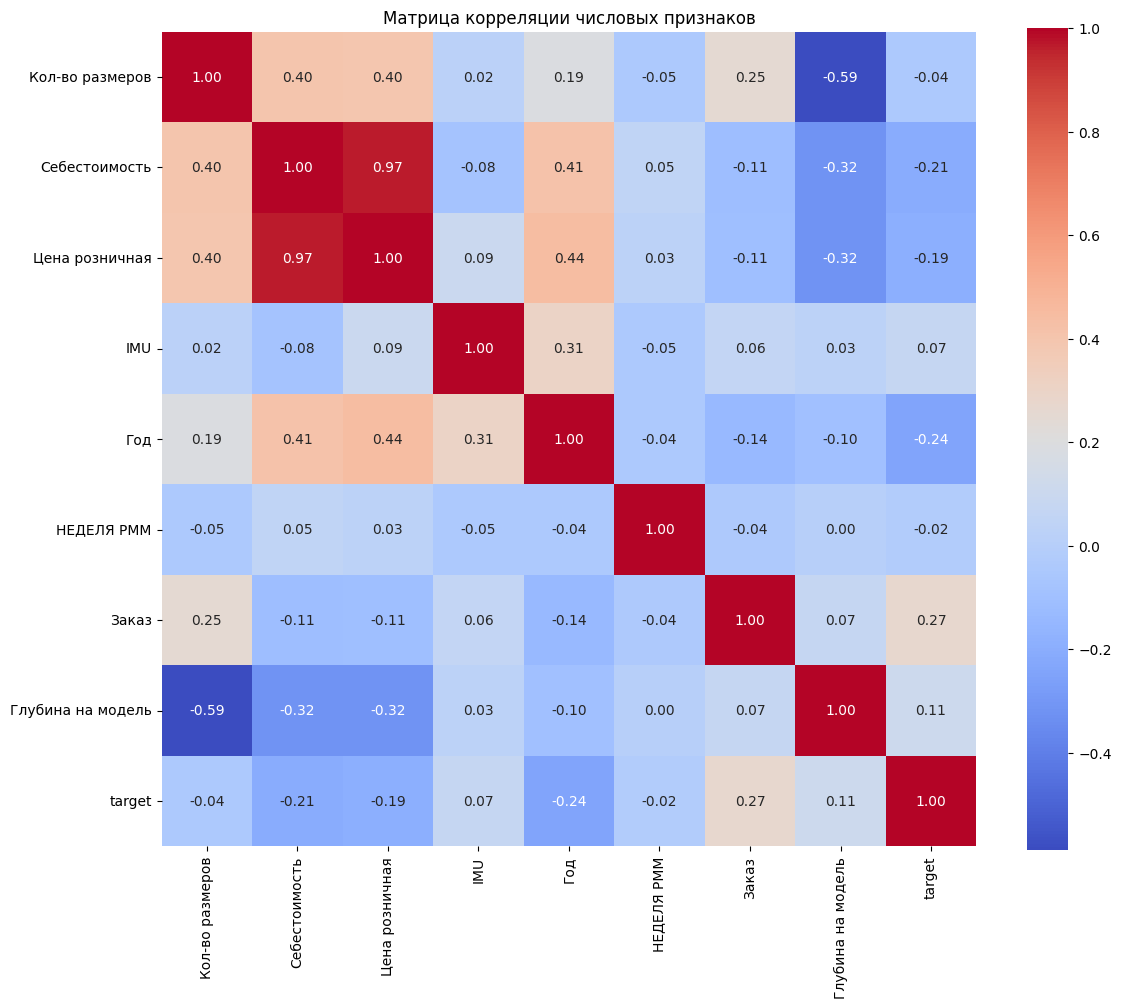

In [47]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("–ú–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")
plt.tight_layout()
plt.show()

–ü–æ—Å–º–æ—Ç—Ä–∏–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è

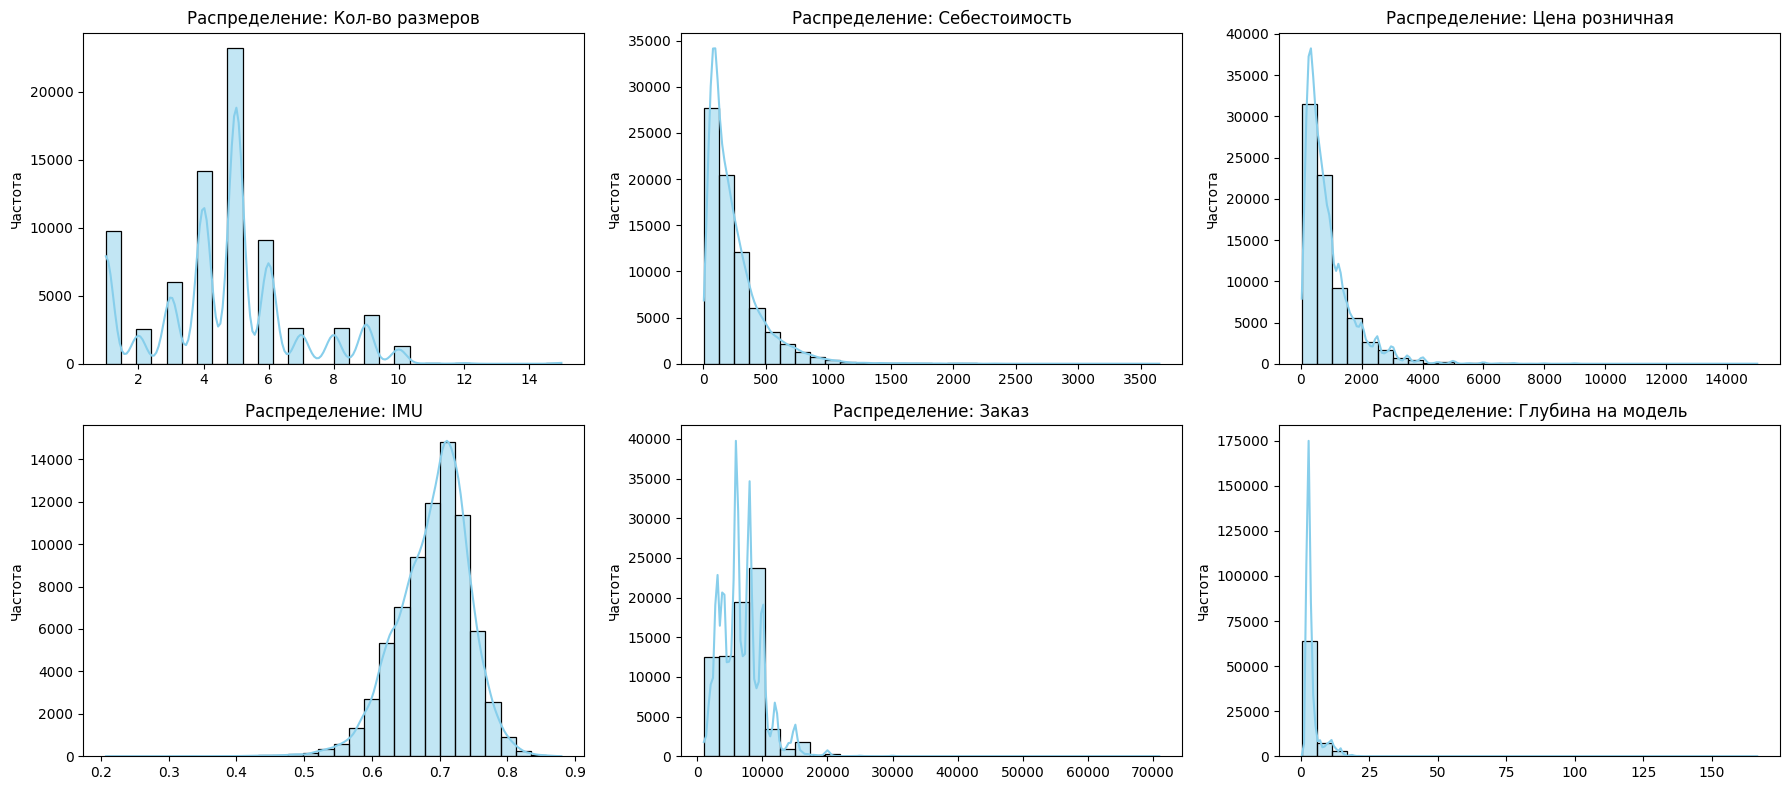

In [48]:
numeric_df = numeric_df.drop(['–ì–æ–¥', '–ù–ï–î–ï–õ–Ø PMM', 'target' ],axis=1)

# –û–ø—Ä–µ–¥–µ–ª–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
cols = numeric_df.columns
n = len(cols)
rows = (n + 2) // 3  # –ø–æ 3 –≥—Ä–∞—Ñ–∏–∫–∞ –≤ —Å—Ç—Ä–æ–∫—É

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –≥—Ä–∞—Ñ–∏–∫–æ–≤
fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(data=numeric_df, x=col, kde=True, ax=axes[i], color='skyblue', bins=30)
    axes[i].set_title(f"–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("–ß–∞—Å—Ç–æ—Ç–∞")

# –£–¥–∞–ª–∏–º –ª–∏—à–Ω–∏–µ –ø—É—Å—Ç—ã–µ –≥—Ä–∞—Ñ–∏–∫–∏
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

–í—ã–¥–µ–ª–∏–º –∏ –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

In [49]:
df.describe(include = 'object')

–¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è –¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞ –¶–µ–ª–µ–≤–∞—è –≥—Ä—É–ø–ø–∞  \
count               75016           75016          75016   
unique                131              30             12   
top         T-SHIRTS S-sl       KNIT TOPS        G13+ GJ   
freq                 9312           13051          23087   

                 –ê—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç –ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ  –∞—Ç—Ä–∏–±—É—Ç1 –∞—Ç—Ä–∏–±—É—Ç2  \
count                  75016                   75016     75016    75016   
unique                     2                       3       417      198   
top     –û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç                  import  Straight    Solid   
freq                   46272                   60239      7359    24279   

        –∞—Ç—Ä–∏–±—É—Ç4 –°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞ –°—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞ –¢–∏–ø —Ç–∫–∞–Ω–∏        –¶–≤–µ—Ç  \
count      75016            75016               75016     75016       75016   
unique       489               21                  11       206         158   
top     No print         Internet               –ö–∏—Ç–∞–π    Jersey  Multicolor   
freq        9730            26408               33736     12134       12421   

       –û–¥–Ω–æ—Ç–æ–Ω–Ω–æ—Å—Ç—å –≠–ª–µ–º–µ–Ω—Ç—ã –¥–∏–∑–∞–π–Ω–∞   –ü–æ—Å–∞–¥–∫–∞    –ú–æ–¥–Ω–æ—Å—Ç—å –¢–∏–ø –ø—Ä–æ–¥—É–∫—Ç–∞  \
count         75016            75016     75016       75016        75016   
unique           25              155       370           9          672   
top           Solid      no elements  standard  Commercial      graphic   
freq          49227            35626     11044       52529         5453   

       –ö–æ–ª–ª–µ–∫—Ü–∏—è –ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã –ú–ï–°–Ø–¶ PMM  
count      75016        75016     75016  
unique         7            4        12  
top          BTS       Medium      July  
freq       32568        57309     11907

–ü–æ —Å—Ç—Ä–æ–∫–µ unique —Å—Ä–∞–∑—É –≤–∏–¥–Ω–æ, —á—Ç–æ —É–Ω–∏–∫–∞–ª—å–Ω–æ—Å—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∑–Ω–∞—á–µ–Ω–∏–π –≤–Ω—É—Ç—Ä–∏ –∞—Ç—Ä–∏–±—É—Ç–æ–≤ —á–∞—Å—Ç–æ –ø—Ä–µ–≤—ã—à–∞–µ—Ç 100 –∏ –ø–æ—ç—Ç–æ–º—É –≤–∏–∑—É–∞–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –∑–∞—Ç—Ä—É–¥–Ω–µ–Ω. –í—ã–¥–µ–ª–∏–º —Ç–æ–ø 50 –∫–∞—Ç–µ–≥–æ—Ä–∏–π, –∞ –æ—Å—Ç–∞–ª—å–Ω—ã–µ –æ–±—ä–µ–¥–∏–Ω–∏–º –≤ Other –∏ –ø–æ—Å–ª–µ –≤—ã–≤–µ–¥–µ–º –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—é —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∫–∞—Ç–µ–≥–æ—Ä–∏–π

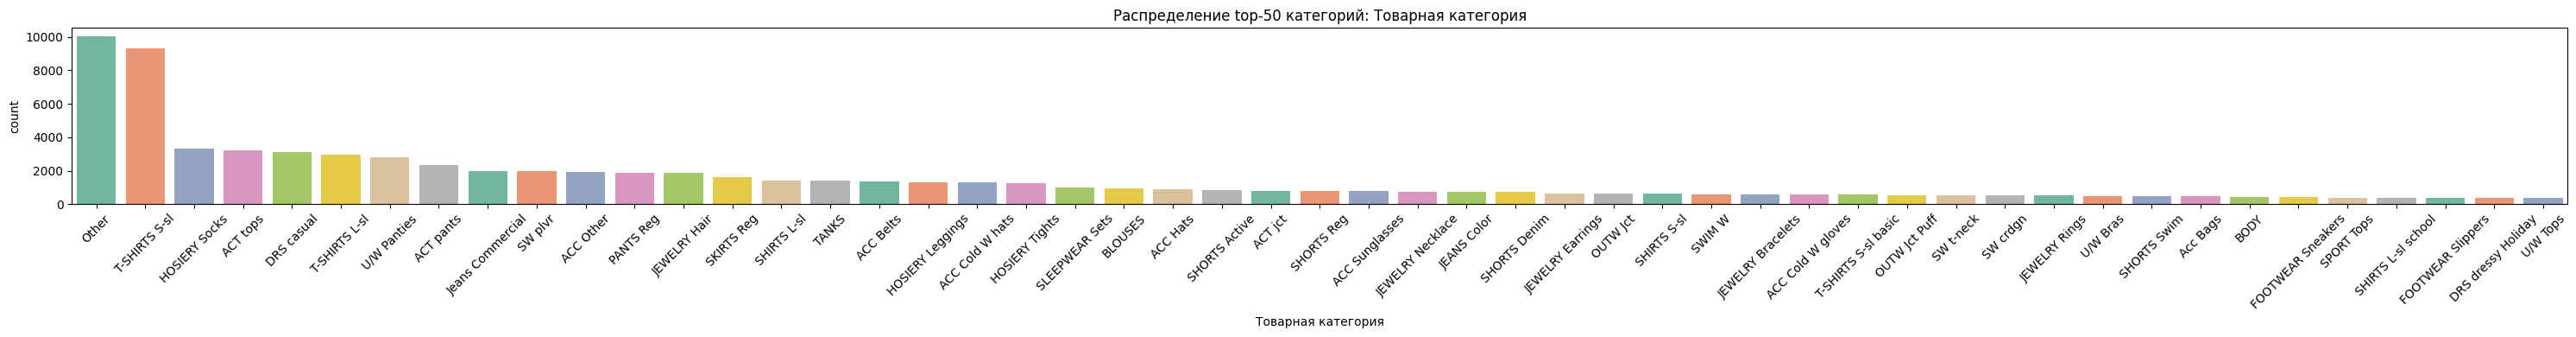

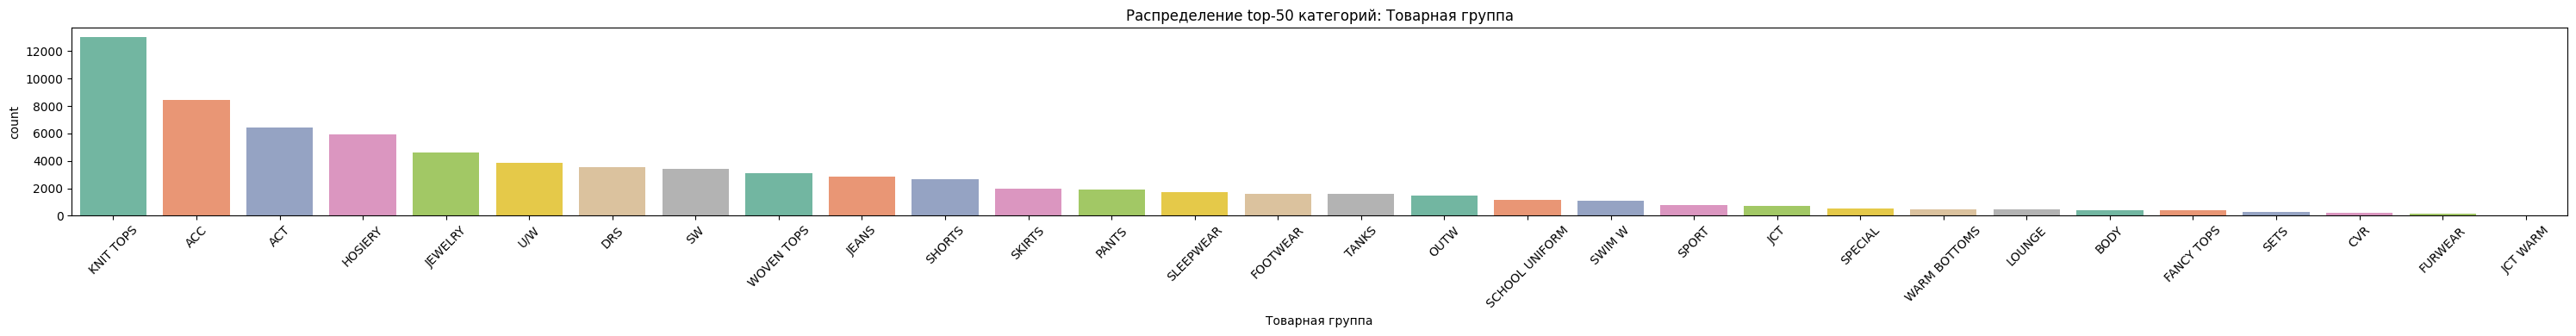

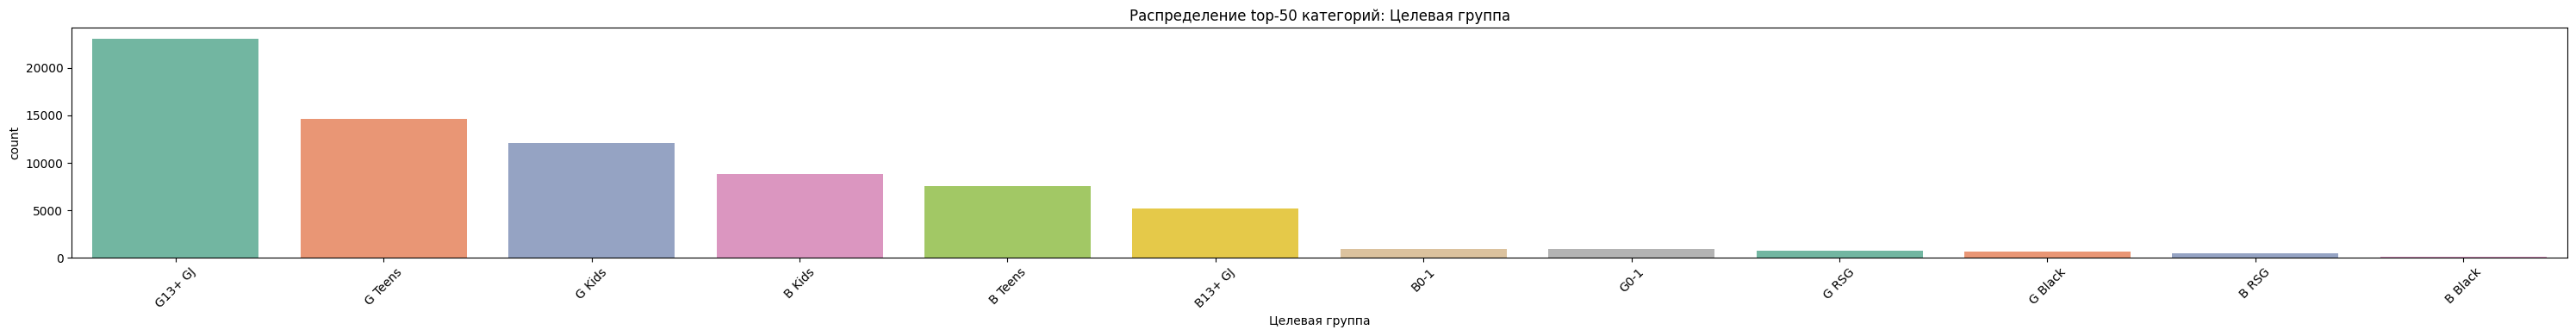

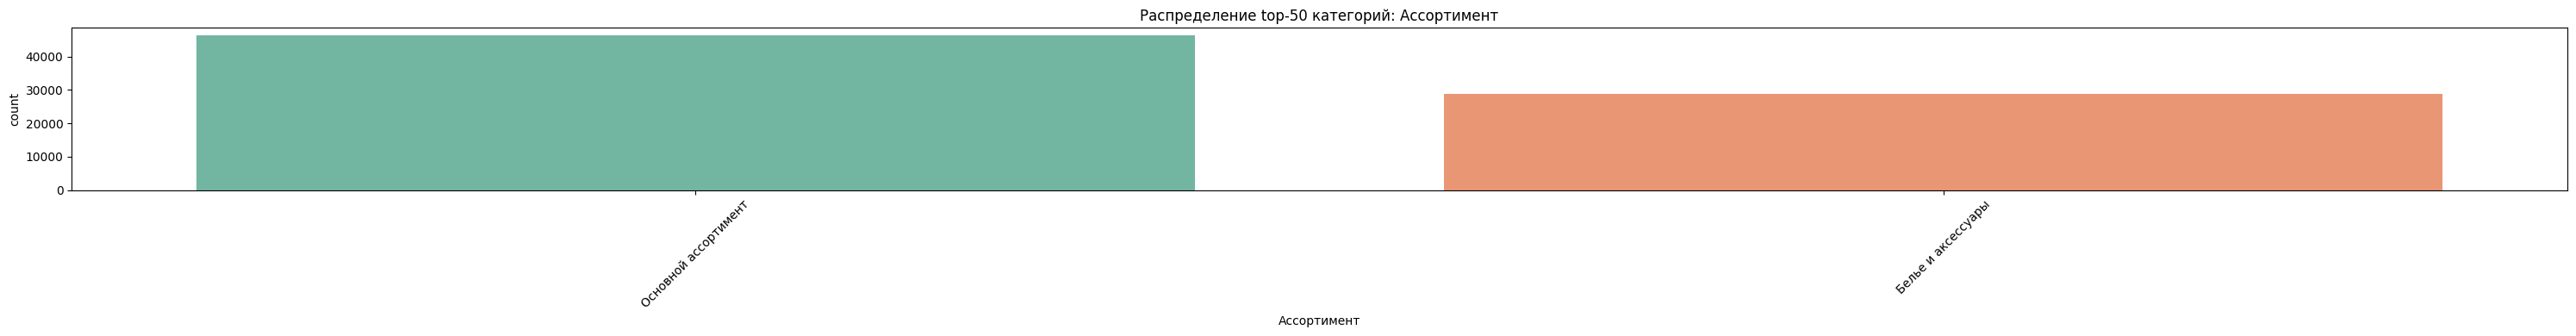

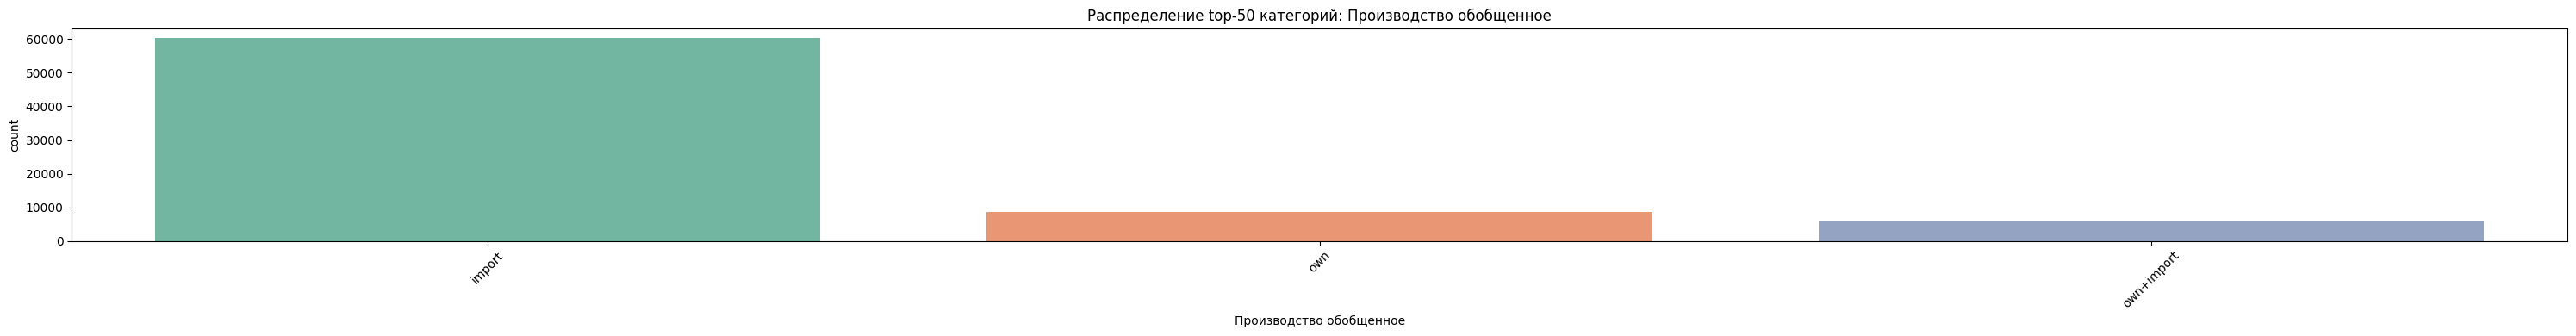

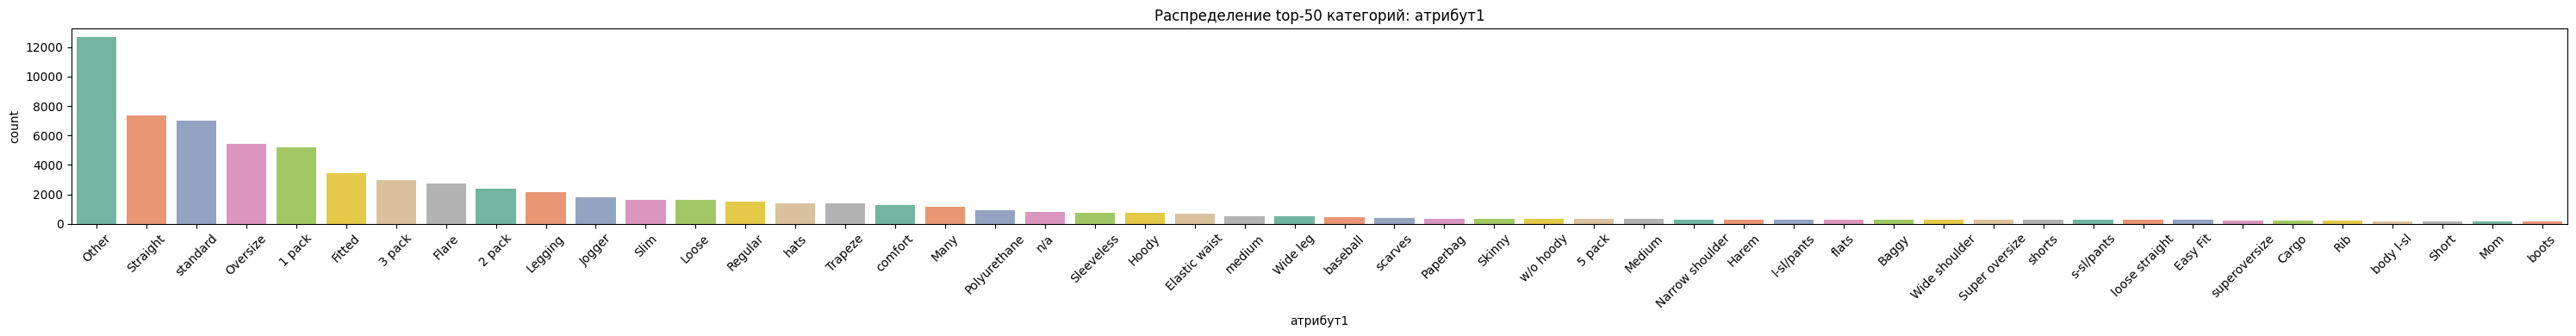

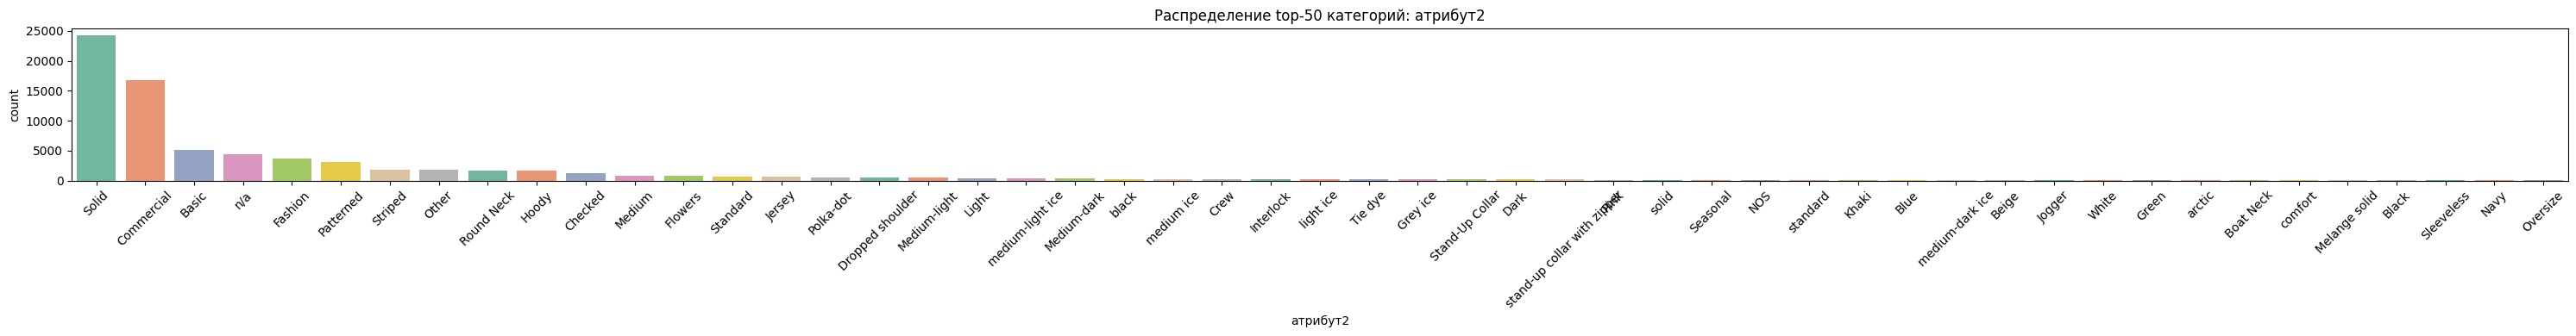

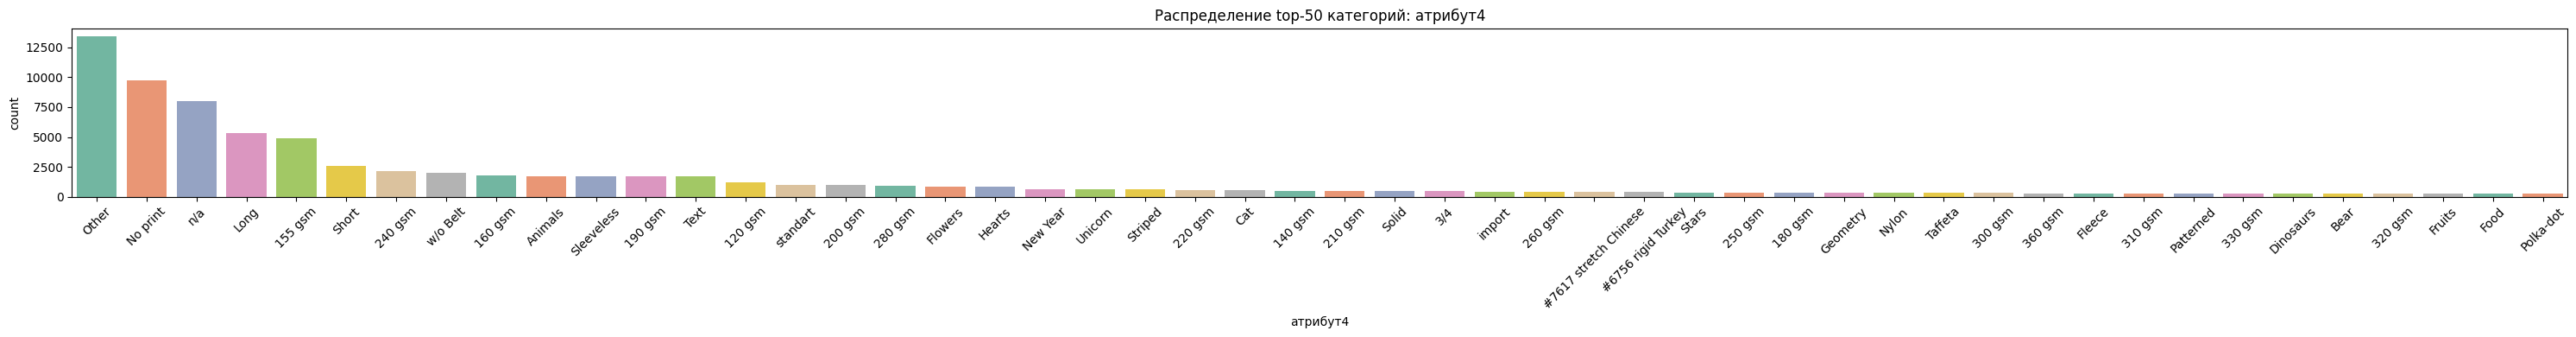

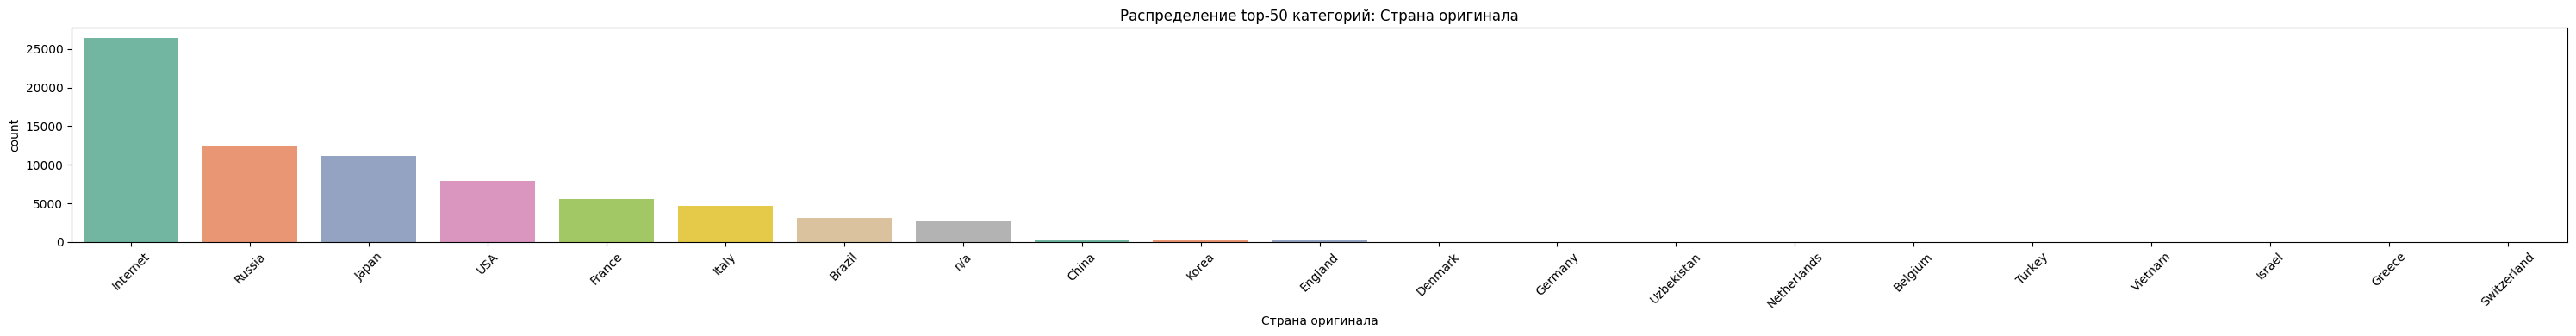

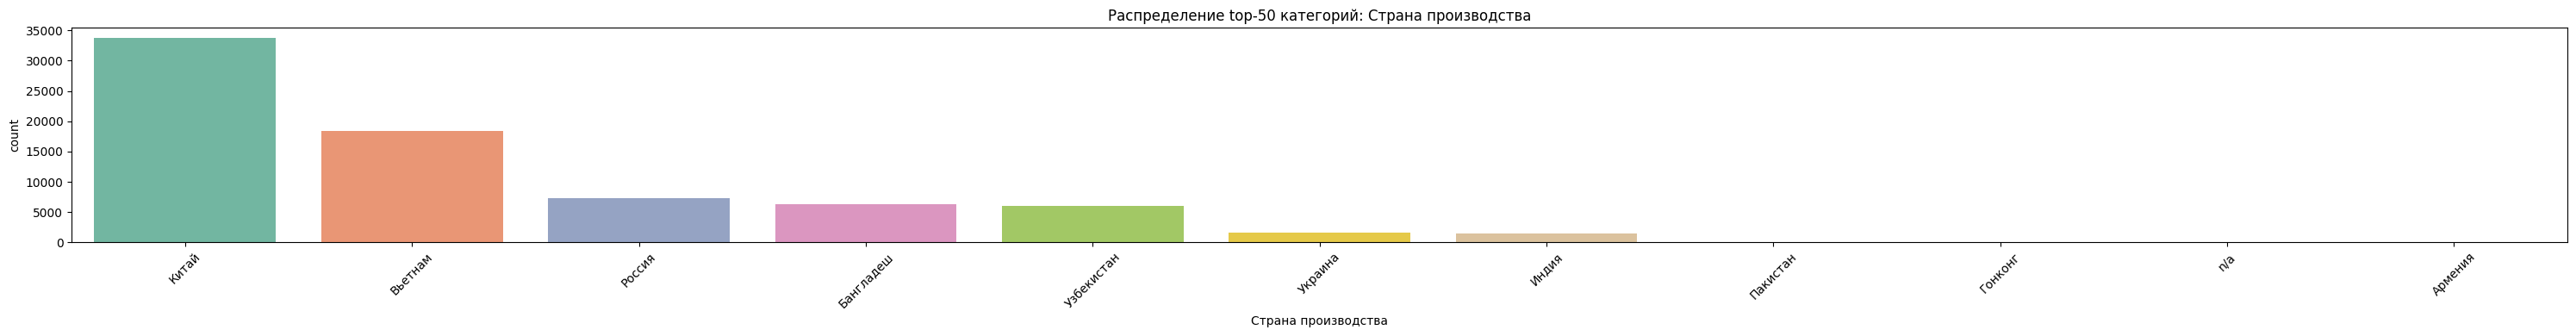

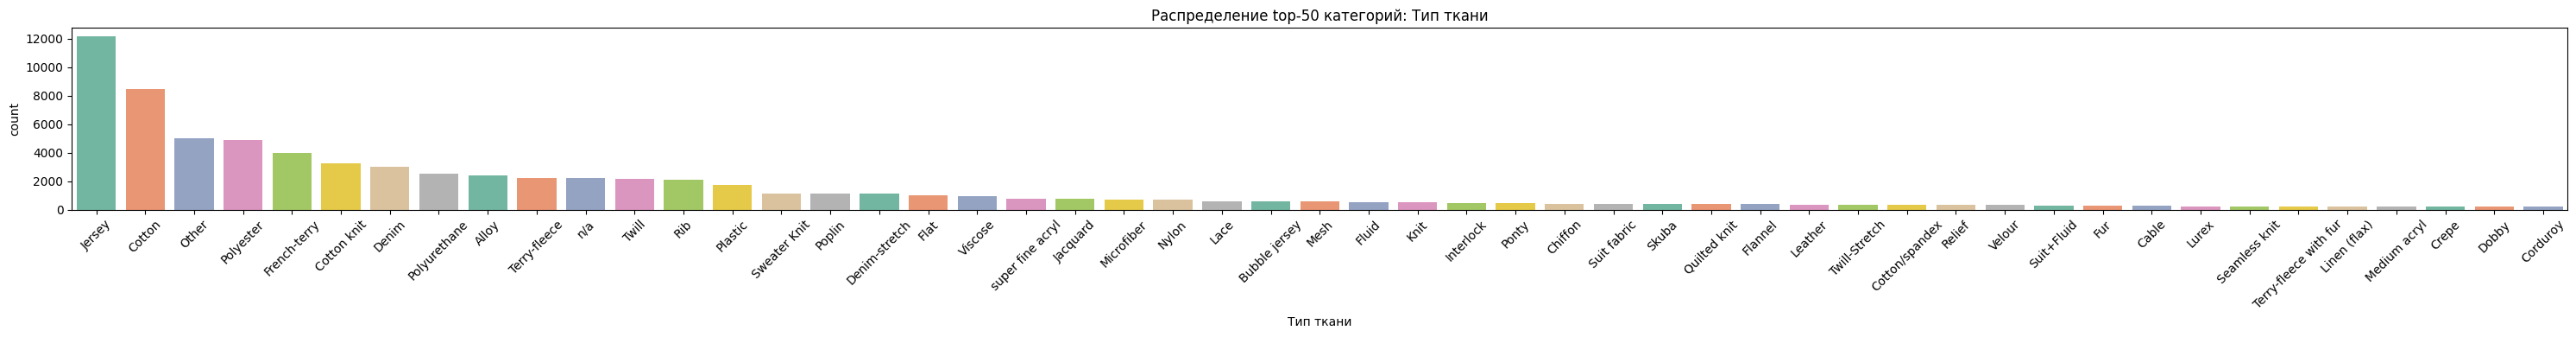

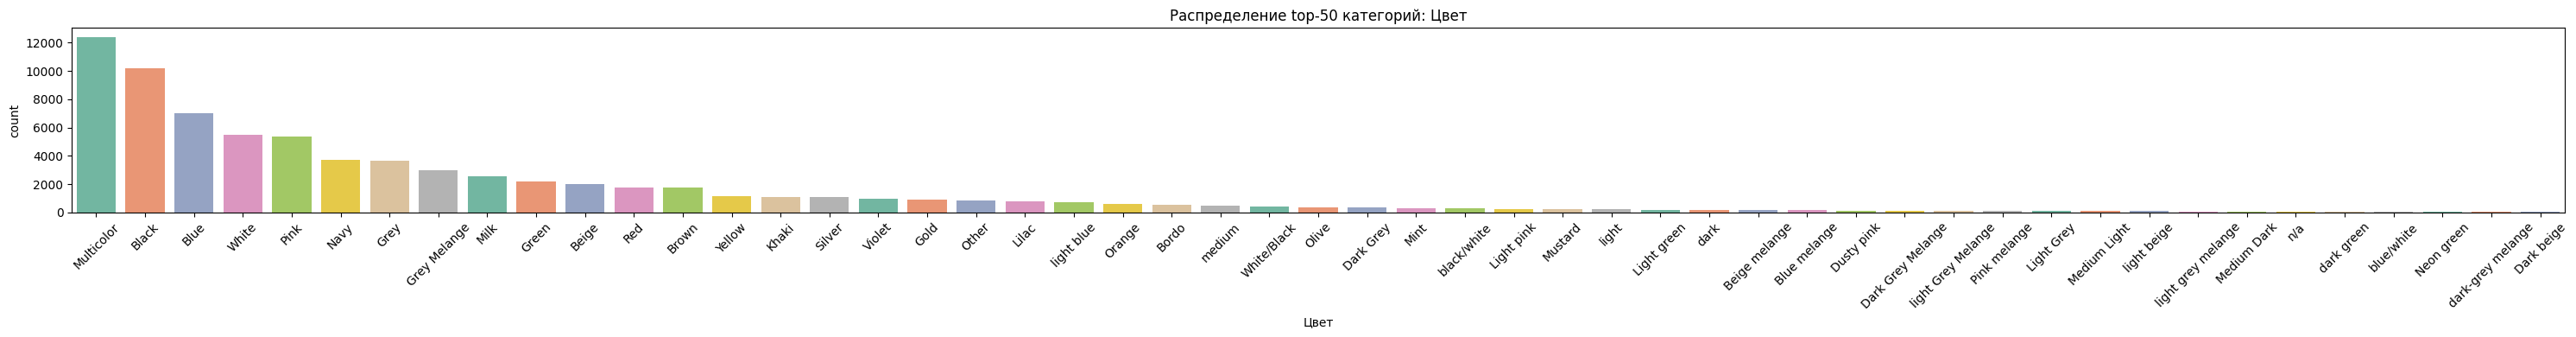

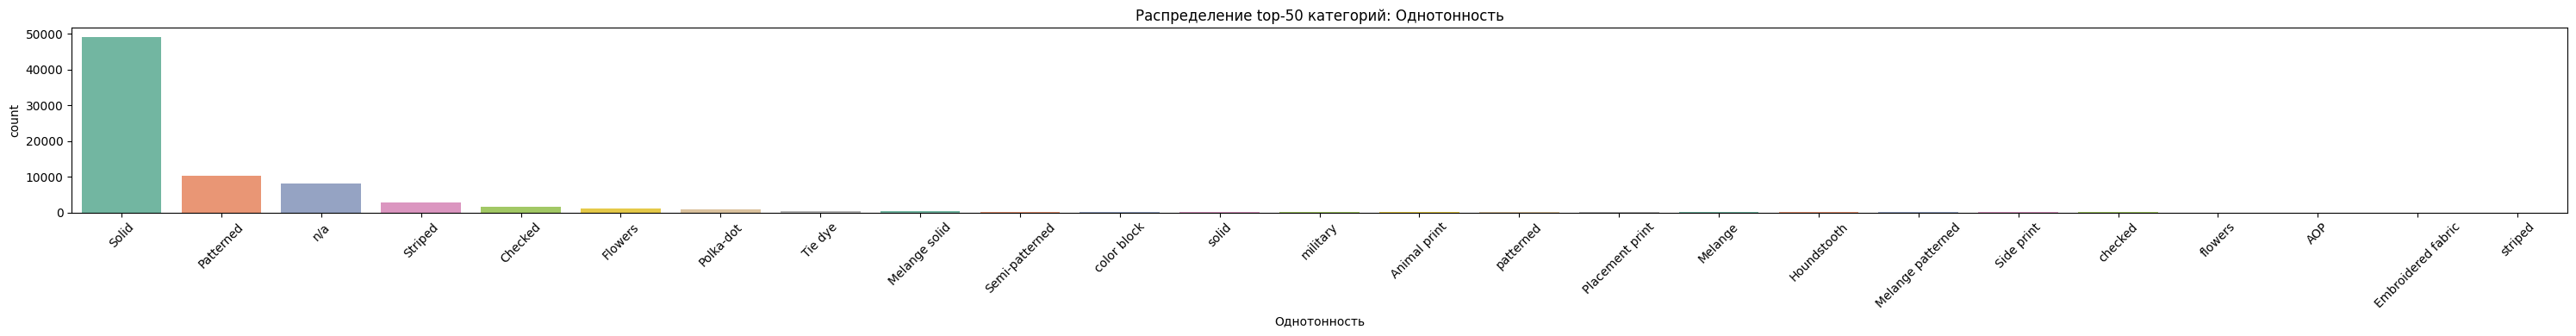

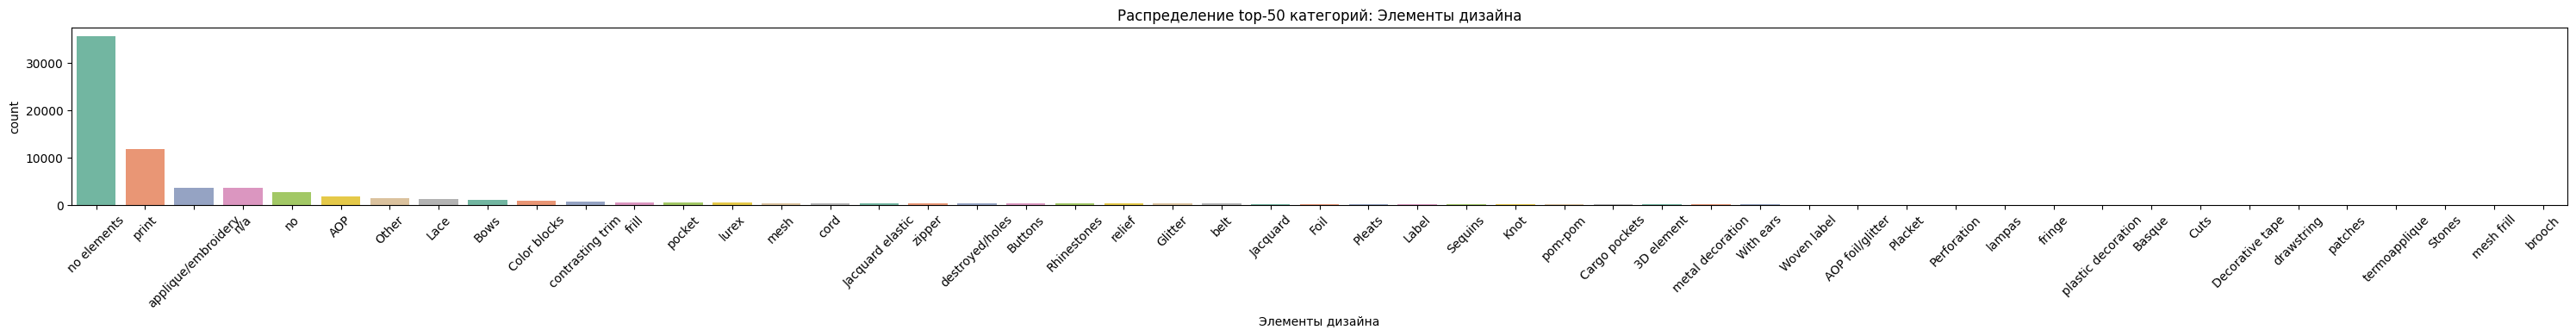

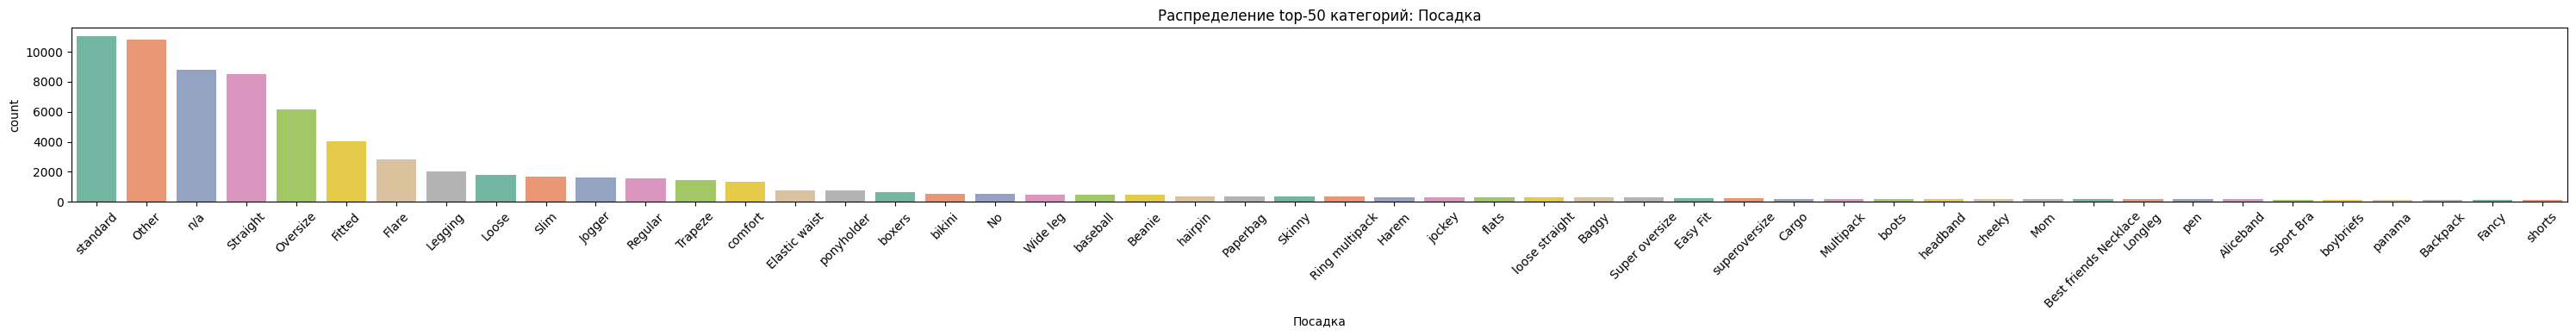

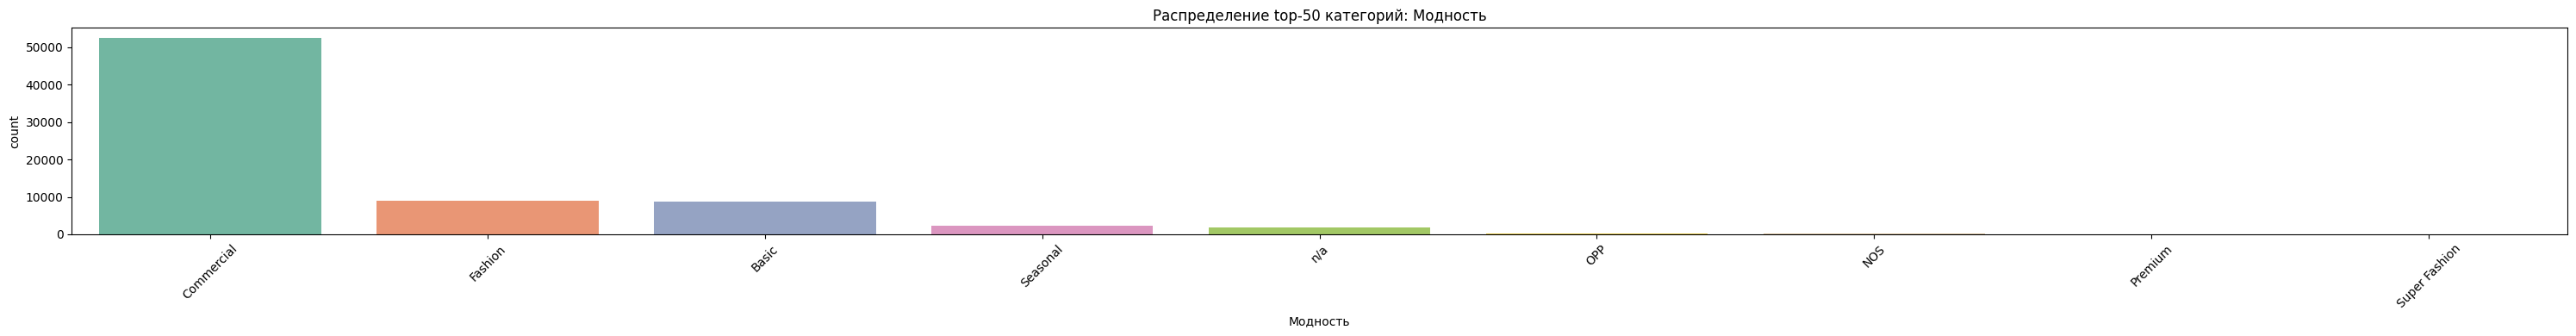

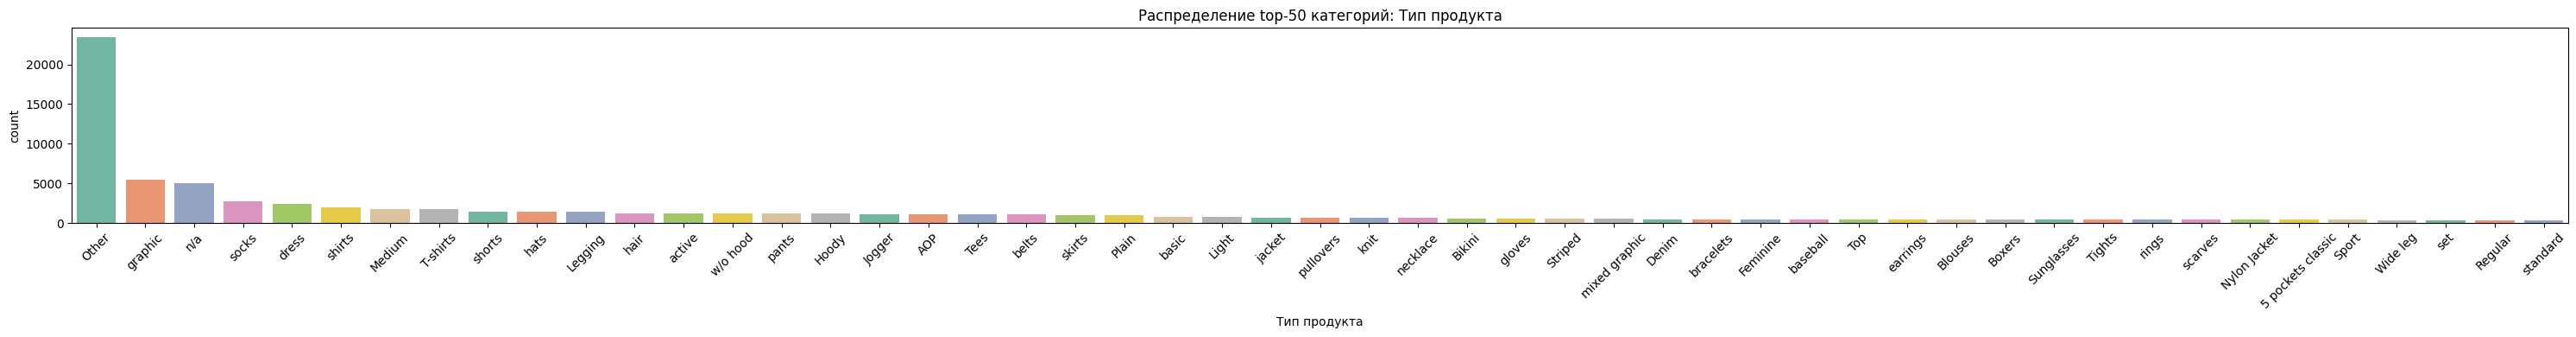

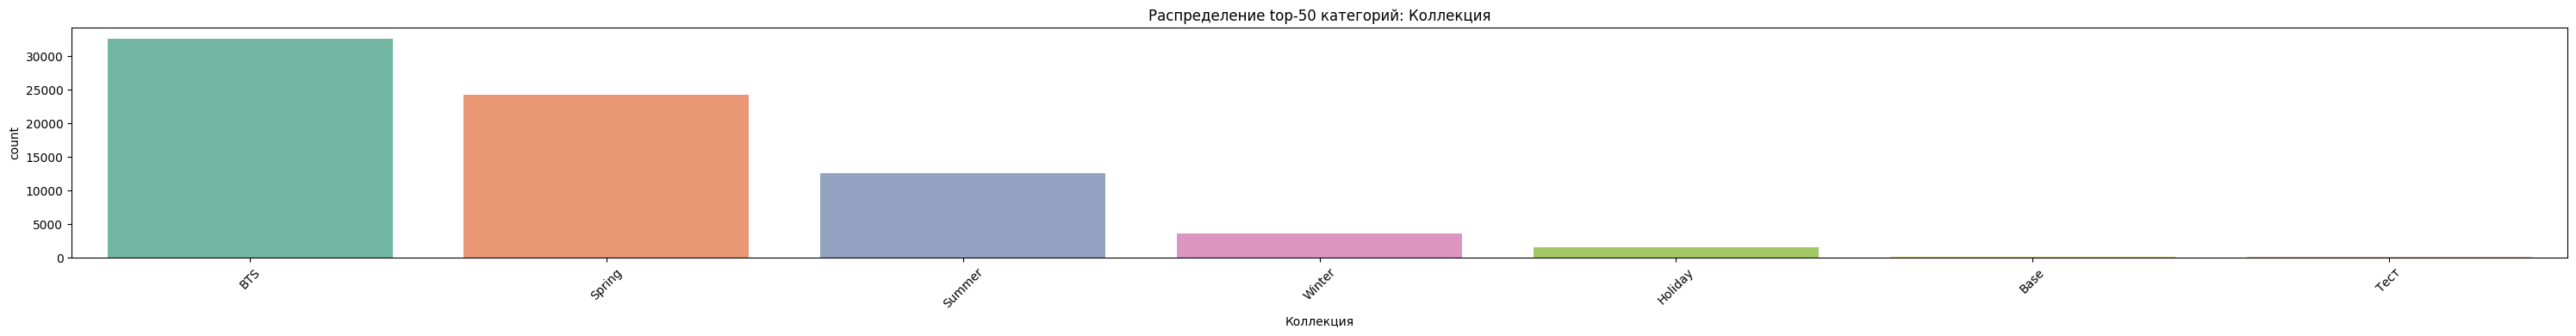

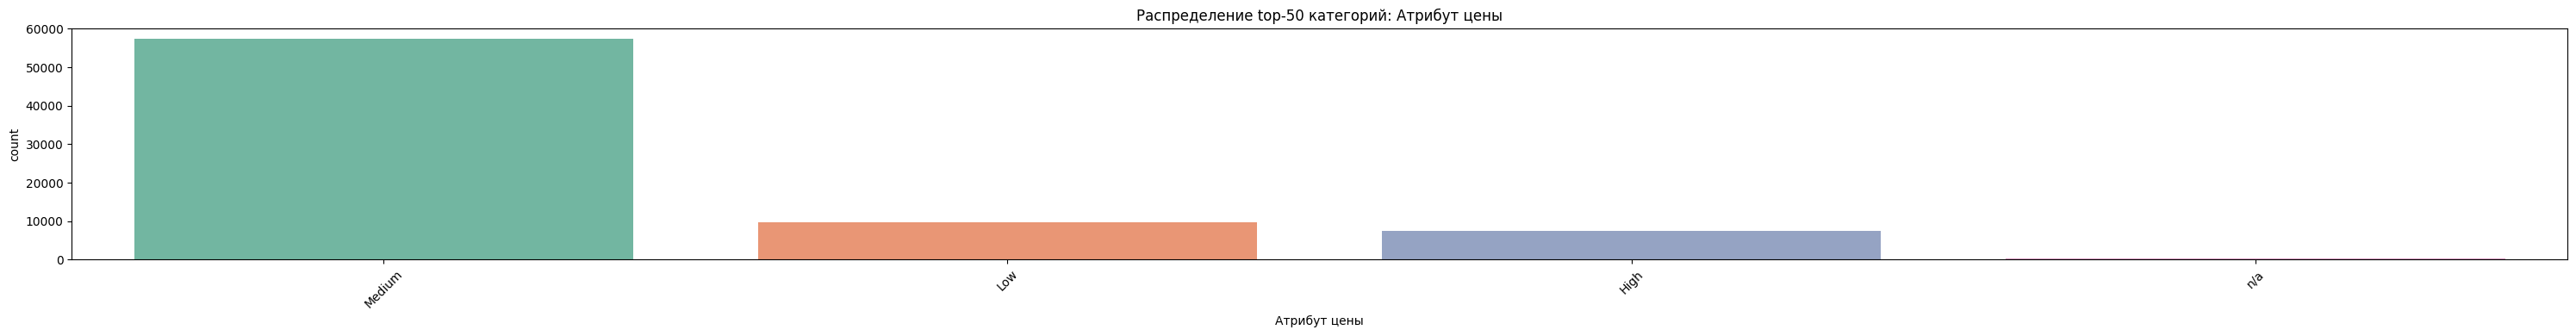

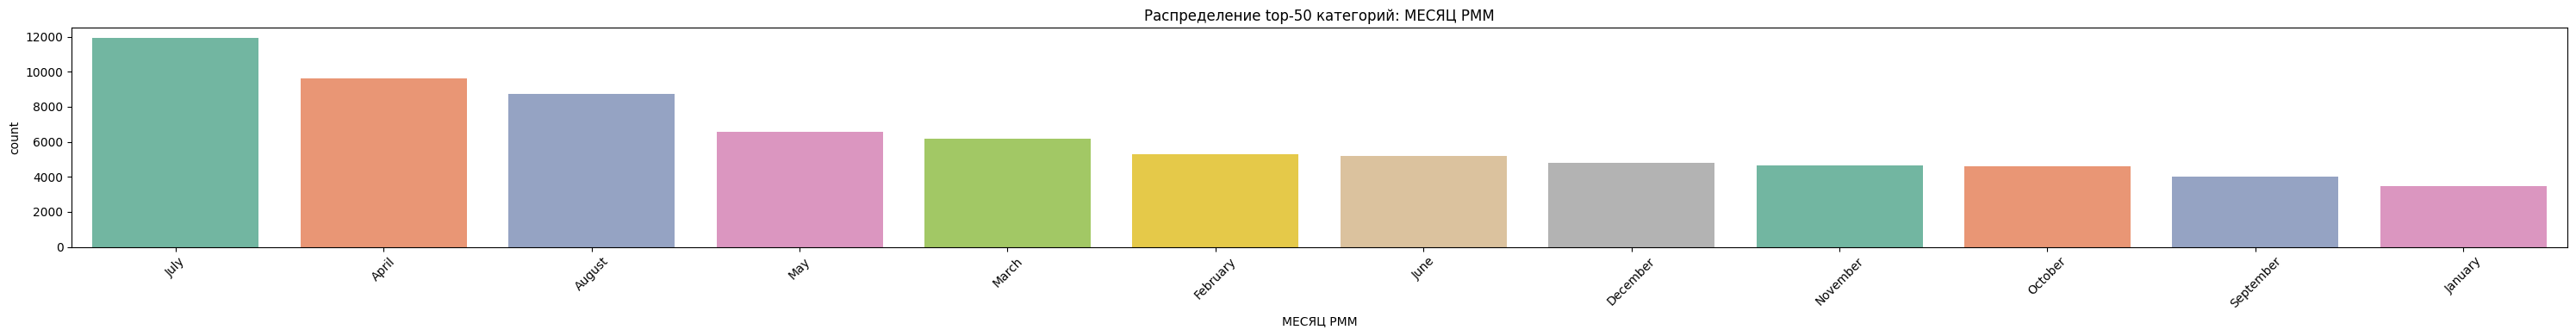

In [50]:
def keep_top_categories(df, col, top_n=50):
    top_categories = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    df = keep_top_categories(df, col, top_n=50)
    
for col in categorical_cols:
    plt.figure(figsize=(30, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette='Set2')
    plt.title(f"–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ top-50 –∫–∞—Ç–µ–≥–æ—Ä–∏–π: {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

–î–∞–ª–µ–µ –≤—ã–¥–µ–ª–∏–º —Ç–æ–ø –∞—Ç—Ä–∏–±—É—Ç–æ–≤ –ø–æ —Å–∏–ª–µ –≤–ª–∏—è–Ω–∏—è –Ω–∞ —Ç–∞—Ä–≥–µ—Ç –∏ –≤—ã–≤–µ–¥–µ–º barplot –¥–ª—è –Ω–∏—Ö

–¢–æ–ø-10 –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ —Å–≤—è–∑–∏ —Å target:
  –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫  Cram√©r's V
0     –¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è    0.217320
1        –¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞    0.214646
2               –∞—Ç—Ä–∏–±—É—Ç4    0.198211
3              –¢–∏–ø —Ç–∫–∞–Ω–∏    0.195814
4           –¢–∏–ø –ø—Ä–æ–¥—É–∫—Ç–∞    0.194269
5               –∞—Ç—Ä–∏–±—É—Ç1    0.188590
6       –°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞    0.173828
7                –ü–æ—Å–∞–¥–∫–∞    0.170549
8               –∞—Ç—Ä–∏–±—É—Ç2    0.165999
9                   –¶–≤–µ—Ç    0.162429


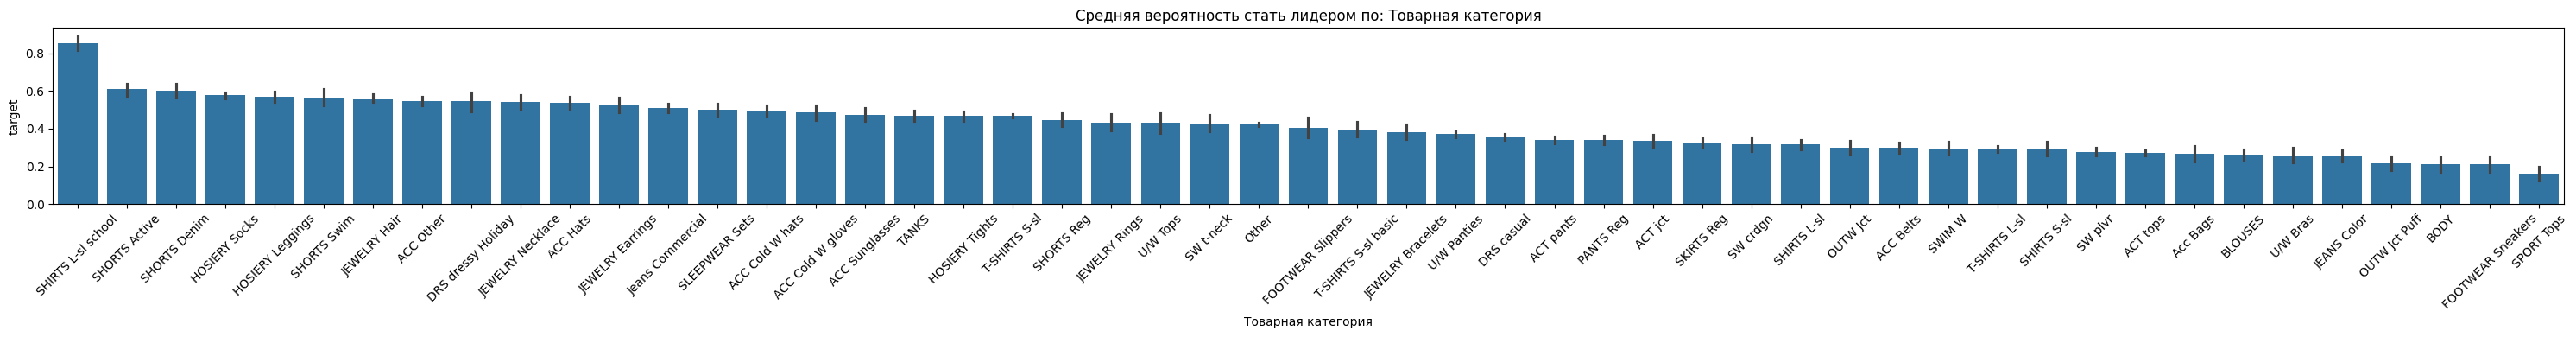

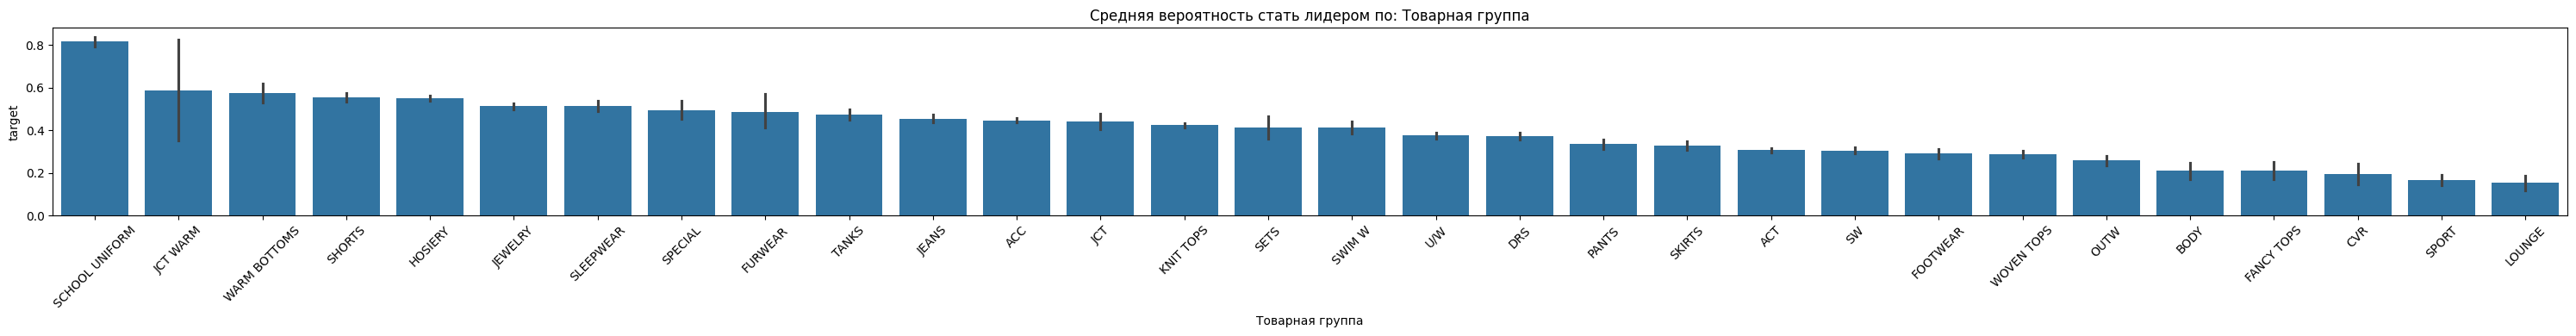

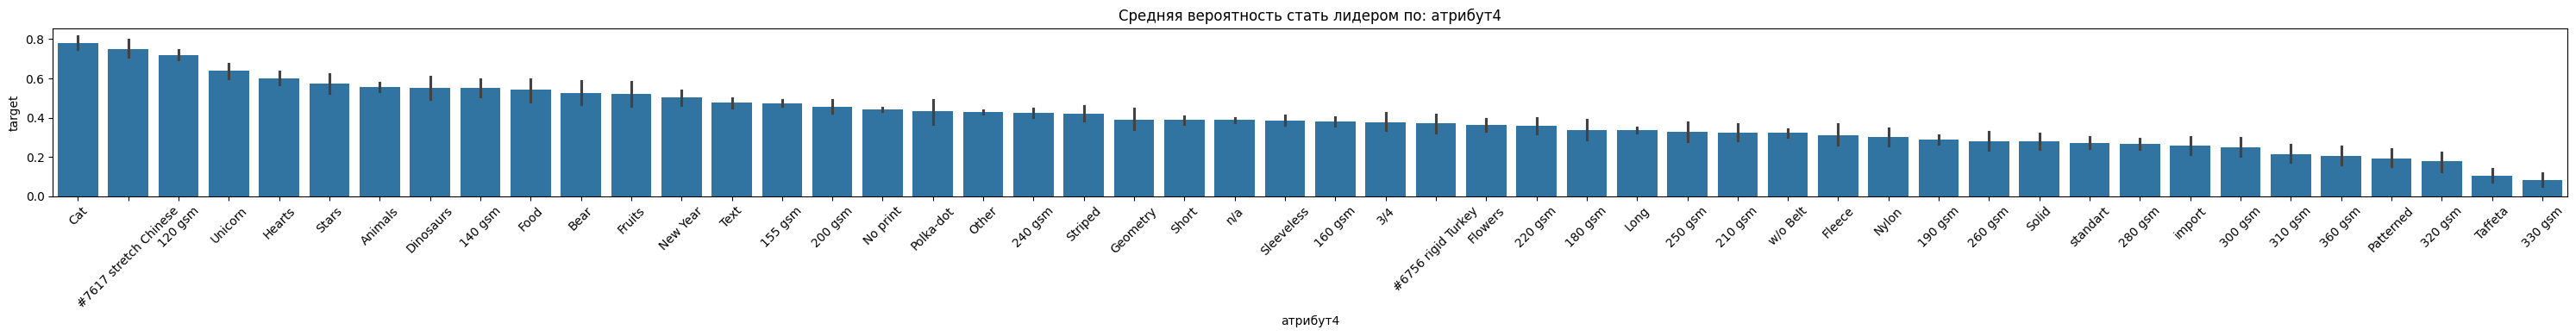

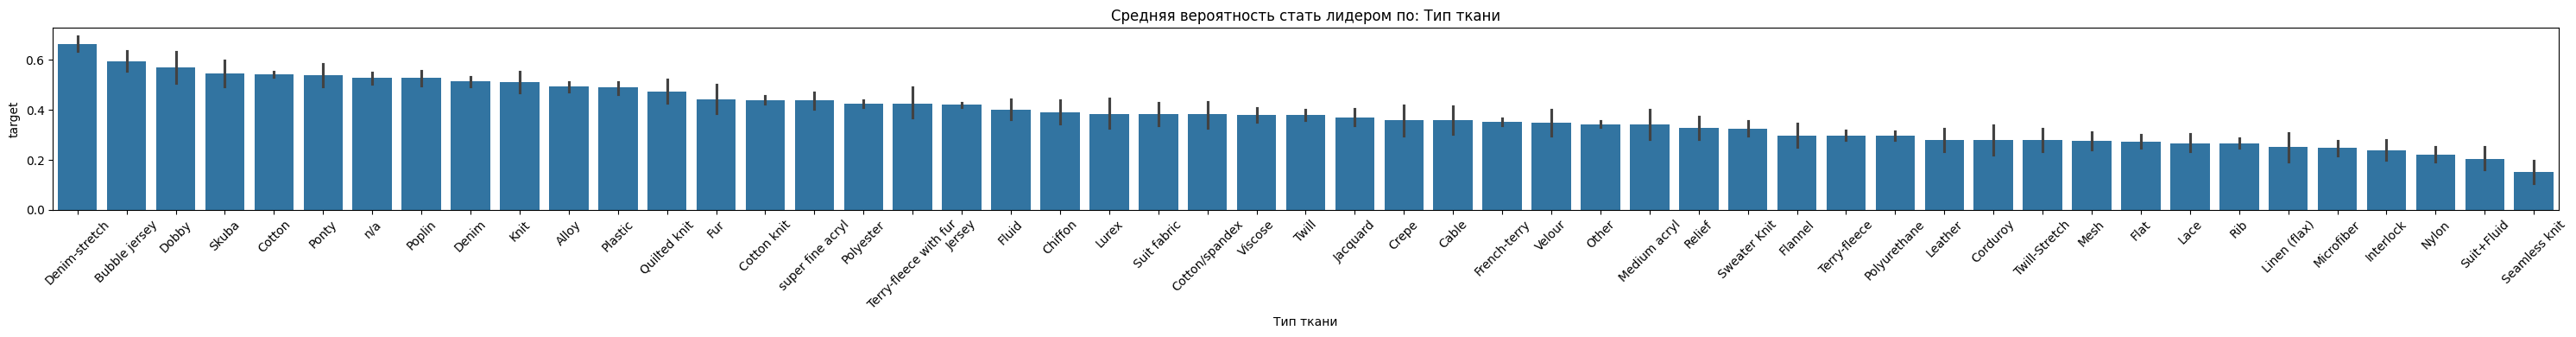

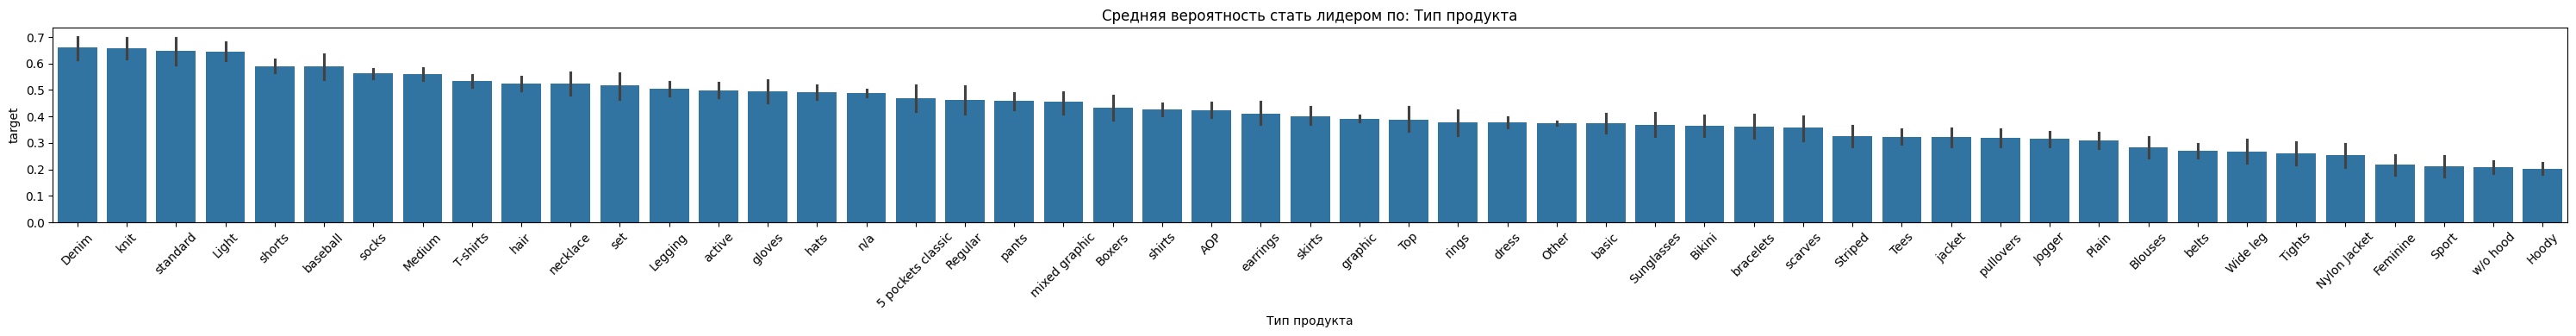

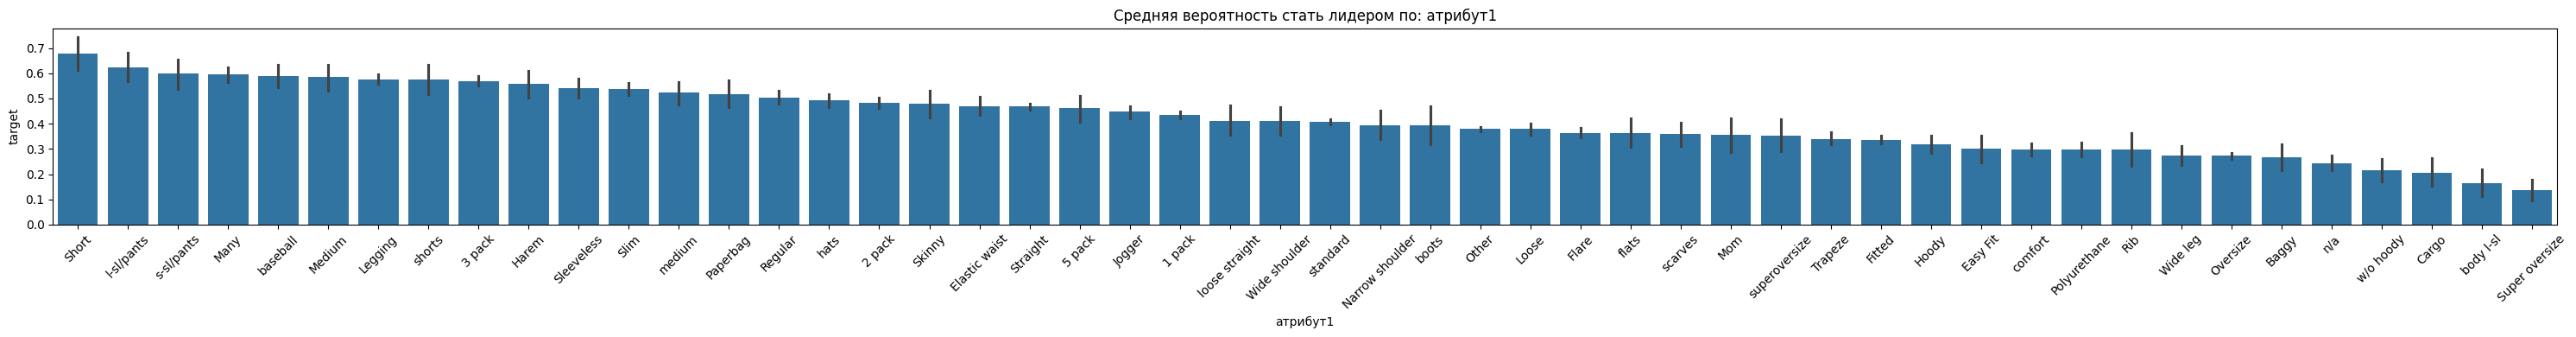

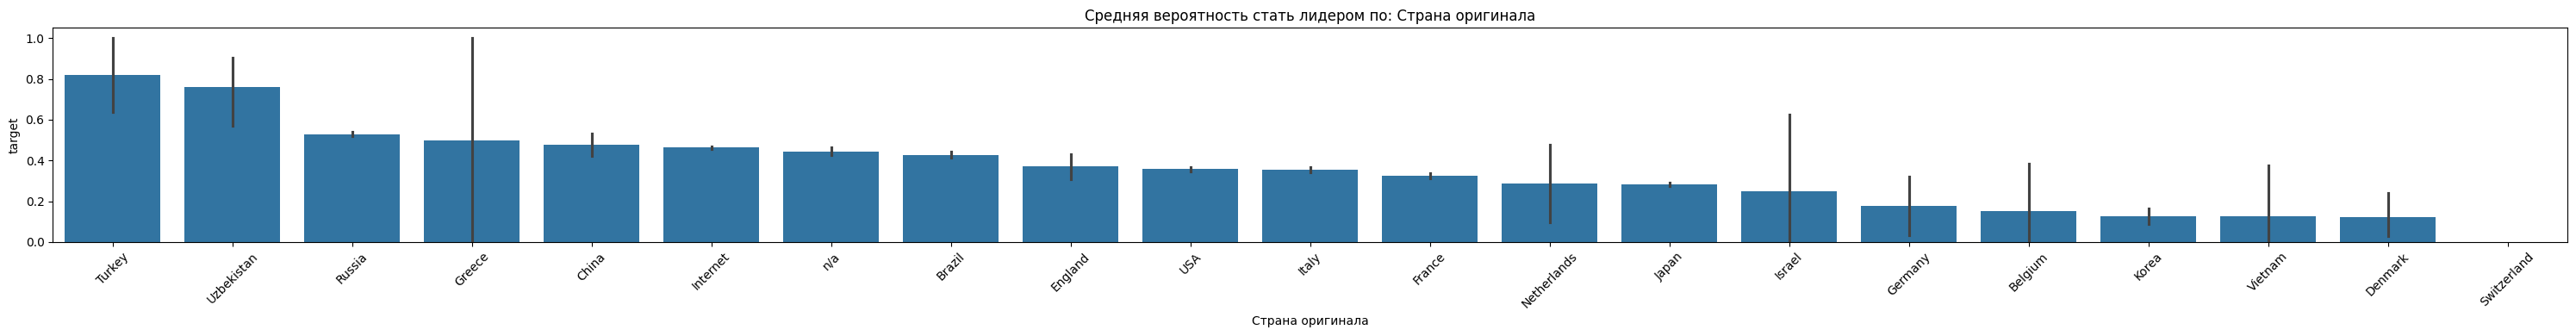

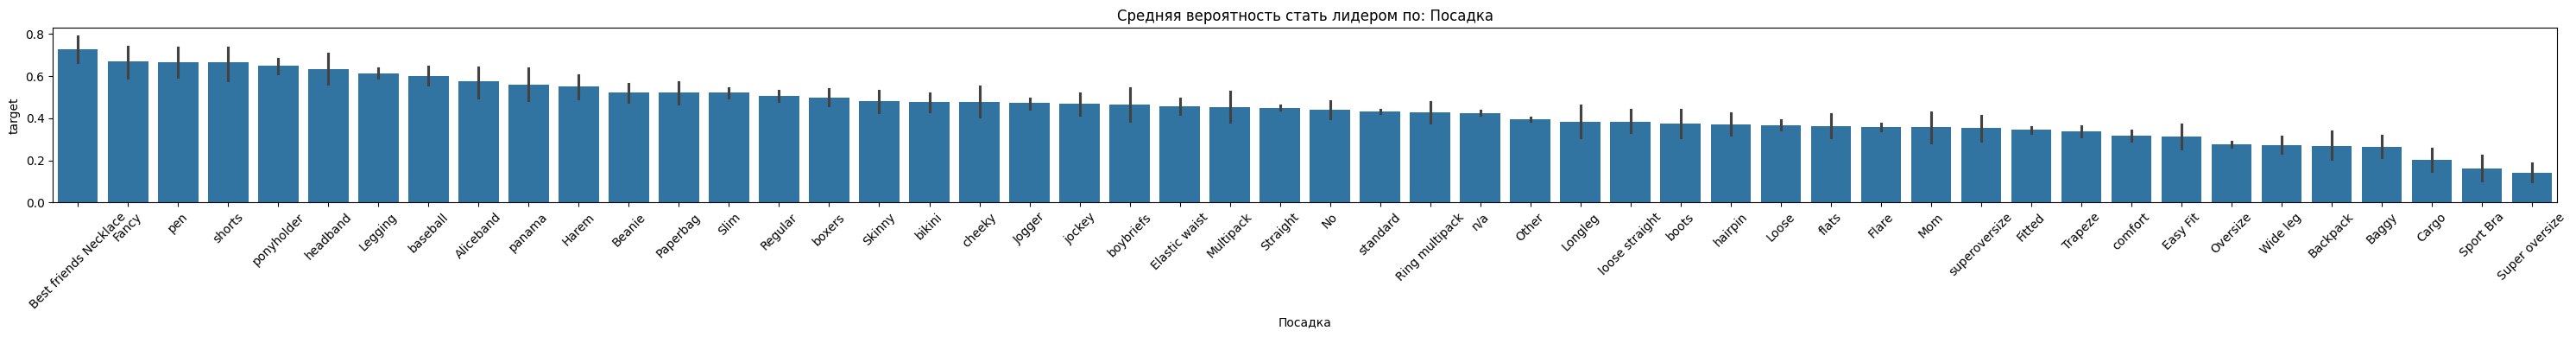

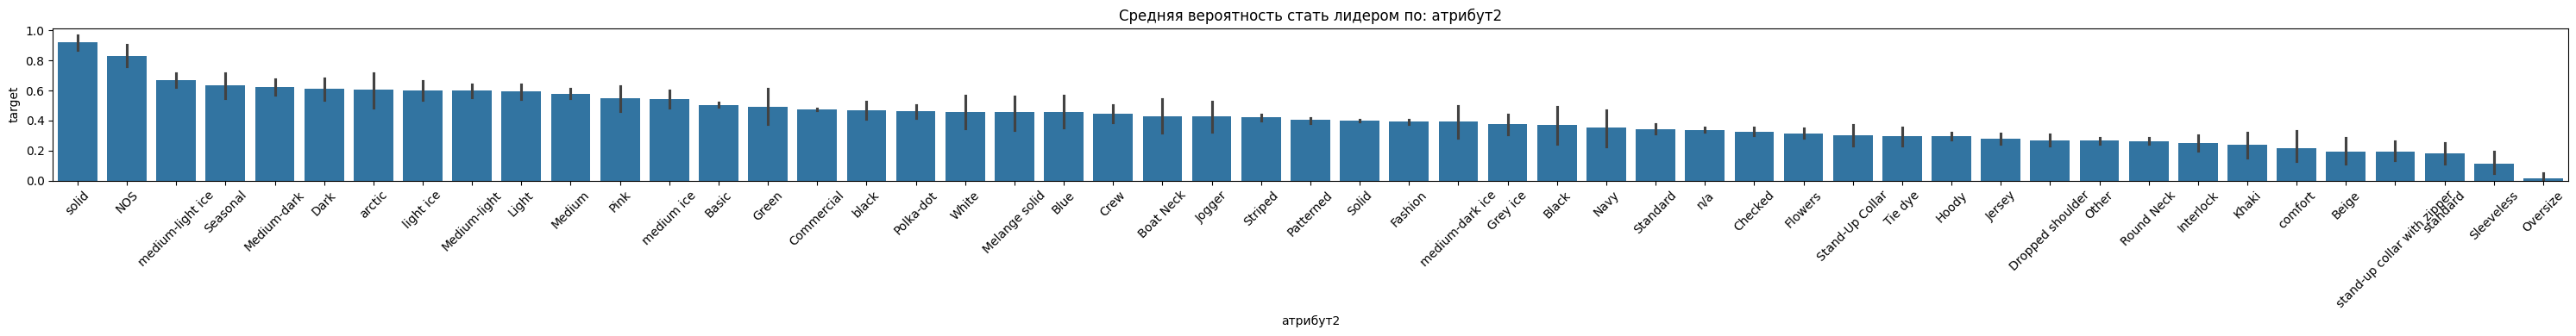

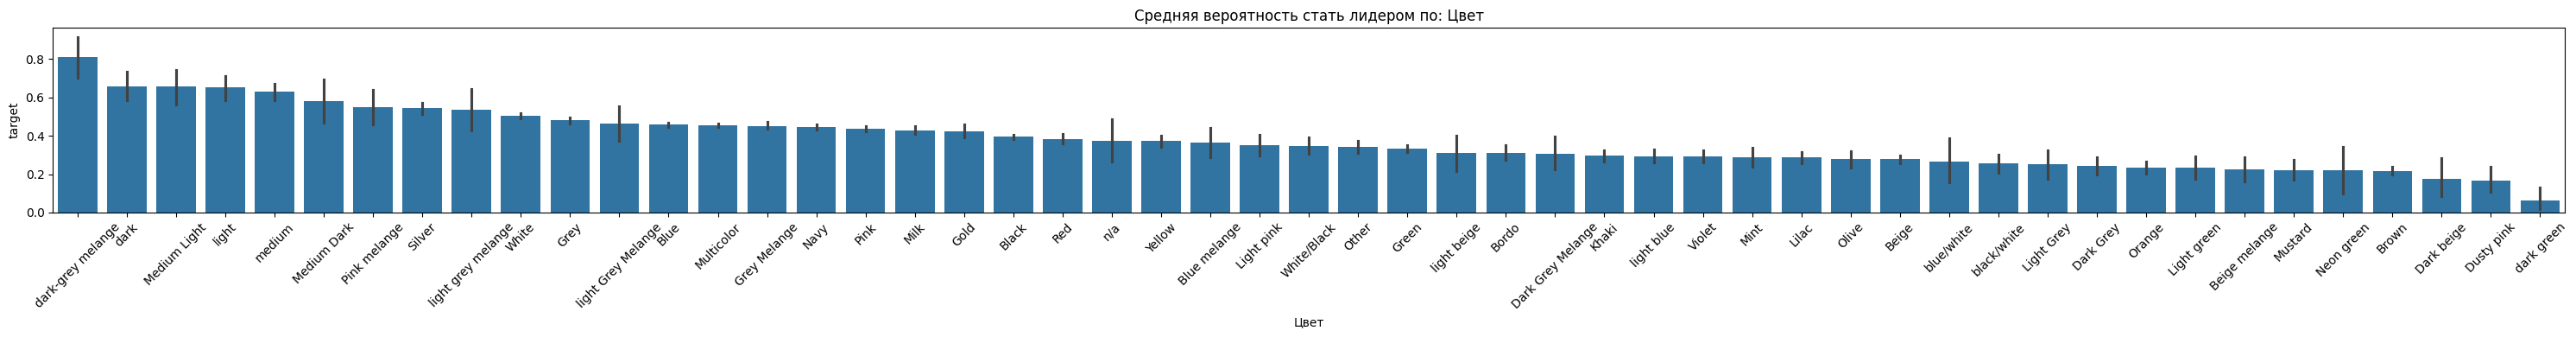

In [51]:
# –§—É–Ω–∫—Ü–∏—è Cram√©r's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else 0

# –†–∞—Å—á–µ—Ç Cram√©r's V –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ —Å —Ç–∞—Ä–≥–µ—Ç–æ–º
cramers_scores = {
    col: cramers_v(df[col], df['target']) for col in categorical_cols
}

# –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –∏ –≤—ã–≤–æ–¥
cramers_sorted = sorted(cramers_scores.items(), key=lambda x: x[1], reverse=True)
top_10 = pd.DataFrame(cramers_sorted[:10], columns=["–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫", "Cram√©r's V"])

print("–¢–æ–ø-10 –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ —Å–≤—è–∑–∏ —Å target:")
print(top_10)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è top_10 –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é barplot

top_10_cols = top_10["–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫"].tolist()  # —Å–ø–∏—Å–æ–∫ –∏–º—ë–Ω –∫–æ–ª–æ–Ω–æ–∫

for col in top_10_cols:
    plt.figure(figsize=(30, 4))
    sns.barplot(x=col, y='target', data=df, 
            order=df.groupby(col)['target'].mean().sort_values(ascending=False).index)
    plt.xticks(rotation=45)
    plt.title(f"–°—Ä–µ–¥–Ω—è—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å —Å—Ç–∞—Ç—å –ª–∏–¥–µ—Ä–æ–º –ø–æ: {col}")
    plt.tight_layout()
    plt.show()


In [39]:
X = df.drop('target',axis=1)
Y = df['target']

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [74]:
categorical_cols=['–¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è','–¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞','–¶–µ–ª–µ–≤–∞—è –≥—Ä—É–ø–ø–∞','–ê—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç','–ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ','–∞—Ç—Ä–∏–±—É—Ç1','–∞—Ç—Ä–∏–±—É—Ç2','–∞—Ç—Ä–∏–±—É—Ç4','–°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞','–°—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞','–¢–∏–ø —Ç–∫–∞–Ω–∏','–¶–≤–µ—Ç','–û–¥–Ω–æ—Ç–æ–Ω–Ω–æ—Å—Ç—å','–≠–ª–µ–º–µ–Ω—Ç—ã –¥–∏–∑–∞–π–Ω–∞','–ü–æ—Å–∞–¥–∫–∞','–ú–æ–¥–Ω–æ—Å—Ç—å','–¢–∏–ø –ø—Ä–æ–¥—É–∫—Ç–∞','–ö–æ–ª–ª–µ–∫—Ü–∏—è','–ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã','–ú–ï–°–Ø–¶ PMM']
numeric_cols=['–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ä–æ–≤','–°–µ–±–µ—Å—Ç–æ–∏–º–æ—Å—Ç—å','–¶–µ–Ω–∞ —Ä–æ–∑–Ω–∏—á–Ω–∞—è','IMU','–ì–æ–¥','–ù–ï–î–ï–õ–Ø PMM','–ó–∞–∫–∞–∑','–ì–ª—É–±–∏–Ω–∞ –Ω–∞ –º–æ–¥–µ–ª—å']

–ó–∞–∫–æ–¥–∏—Ä—É–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

In [75]:
encoder = MixedCategoricalEncoder(threshold=5)
encoder.fit(X_train[categorical_cols], Y_train)

MixedCategoricalEncoder()

In [76]:
X_train_cat = encoder.transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

In [77]:
X_train_full = pd.concat([X_train[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_test[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

In [78]:
X_test_full.head()

–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ä–æ–≤  –°–µ–±–µ—Å—Ç–æ–∏–º–æ—Å—Ç—å  –¶–µ–Ω–∞ —Ä–æ–∑–Ω–∏—á–Ω–∞—è       IMU   –ì–æ–¥  –ù–ï–î–ï–õ–Ø PMM  \
0                4             74             249  0.673092  2017          52   
1                1             92             399  0.723308  2024          12   
2                3             28             129  0.739535  2019           2   
3                3            130             399  0.665105  2018          50   
4               10           1022            2999  0.620694  2024          27   

   –ó–∞–∫–∞–∑  –ì–ª—É–±–∏–Ω–∞ –Ω–∞ –º–æ–¥–µ–ª—å  –¢–æ–≤–∞—Ä–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è  –¢–æ–≤–∞—Ä–Ω–∞—è –≥—Ä—É–ø–ø–∞  \
0  10000           4.386726            0.465578         0.424003   
1   6000          10.638298            0.478191         0.451929   
2   8000           4.875076            0.576207         0.546183   
3  10000           6.245742            0.295075         0.424003   
4   3000           2.048092            0.508070         0.454020   

   –¶–µ–ª–µ–≤–∞—è –≥—Ä—É–ø–ø–∞  –∞—Ç—Ä–∏–±—É—Ç1  –∞—Ç—Ä–∏–±—É—Ç2  –∞—Ç—Ä–∏–±—É—Ç4  –°—Ç—Ä–∞–Ω–∞ –æ—Ä–∏–≥–∏–Ω–∞–ª–∞  \
0        0.416678  0.469304  0.400258  0.481804          0.463748   
1        0.379477  0.300000  0.471638  0.386106          0.463748   
2        0.391198  0.431829  0.471638  0.519608          0.463748   
3        0.451345  0.469304  0.400258  0.377038          0.525313   
4        0.379477  0.469304  0.370130  0.090909          0.281392   

   –°—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞  –¢–∏–ø —Ç–∫–∞–Ω–∏      –¶–≤–µ—Ç  –û–¥–Ω–æ—Ç–æ–Ω–Ω–æ—Å—Ç—å  –≠–ª–µ–º–µ–Ω—Ç—ã –¥–∏–∑–∞–π–Ω–∞  \
0             0.392741   0.420547  0.475765      0.401952          0.509350   
1             0.391106   0.484432  0.423604      0.401952          0.380512   
2             0.521295   0.541045  0.396604      0.447301          0.509350   
3             0.392741   0.420547  0.454359      0.401952          0.509350   
4             0.521295   0.271930  0.475765      0.401952          0.380512   

    –ü–æ—Å–∞–¥–∫–∞  –ú–æ–¥–Ω–æ—Å—Ç—å  –¢–∏–ø –ø—Ä–æ–¥—É–∫—Ç–∞  –ö–æ–ª–ª–µ–∫—Ü–∏—è  –ú–ï–°–Ø–¶ PMM  \
0  0.450986  0.514599      0.688259   0.408072   0.376431   
1  0.300000  0.408439      0.376147   0.452604   0.383567   
2  0.420137  0.408439      0.559890   0.408072   0.332495   
3  0.450986  0.408439      0.388491   0.408072   0.376431   
4  0.450986  0.408439      0.000000   0.404944   0.450322   

   –ê—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç_–û—Å–Ω–æ–≤–Ω–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç  –ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ_own  \
0                                 1                            0   
1                                 0                            0   
2                                 0                            0   
3                                 1                            0   
4                                 1                            1   

   –ü—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–µ_own+import  –ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã_Low  –ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã_Medium  \
0                                   0                 1                    0   
1                                   0                 0                    1   
2                                   0                 1                    0   
3                                   0                 0                    0   
4                                   0                 1                    0   

   –ê—Ç—Ä–∏–±—É—Ç —Ü–µ–Ω—ã_n/a  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

–õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è –†–µ–≥—Ä–µ—Å—Å–∏—è

In [79]:
pipe_log = Pipeline([('Scaler',StandardScaler()),('LR',LogisticRegression(class_weight='balanced'))])
pipe_log.fit(X_train_full,Y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('LR', LogisticRegression(class_weight='balanced'))])

In [80]:
y_pred_log = pipe_log.predict(X_test_full)
y_proba_log = pipe_log.predict_proba(X_test_full)[:, 1]
print("LogisticRegression_STScaler :\n", classification_report(Y_test, y_pred_log, digits=3))

LogisticRegression_STScaler :
               precision    recall  f1-score   support

         0.0      0.766     0.679     0.720      8791
         1.0      0.608     0.707     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



In [81]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_log).ravel()

print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')

True Negative: 5965
False Positive: 2826
False Negative: 1821
True Positive: 4392


–õ–∏–Ω–µ–π–Ω—ã–π SVM

In [84]:
from sklearn.svm import LinearSVC
pipe_svm = Pipeline([('Scaler',StandardScaler()),('LR',LinearSVC(class_weight='balanced'))])
pipe_svm.fit(X_train_full,Y_train)


y_pred_svm = pipe_svm.predict(X_test_full)
y_scores_svm= pipe_svm.decision_function(X_test_full)    #LinearSVC –Ω–µ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ—Ç –º–µ—Ç–æ–¥ .predict_proba(). –ò—Å–ø–æ–ª—å–∑—É–µ–º decision_function - –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç –Ω–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏, –∞ –æ—Ü–µ–Ω–∫—É —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –¥–æ –≥—Ä–∞–Ω–∏—Ü—ã

print("LinearSVC:\n", classification_report(Y_test, y_pred_svm, digits=3))

LinearSVC:
               precision    recall  f1-score   support

         0.0      0.767     0.677     0.719      8791
         1.0      0.608     0.708     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



In [85]:
pipe_svm.get_params()

{'memory': None,
 'steps': [('Scaler', StandardScaler()),
  ('LR', LinearSVC(class_weight='balanced'))],
 'transform_input': None,
 'verbose': False,
 'Scaler': StandardScaler(),
 'LR': LinearSVC(class_weight='balanced'),
 'Scaler__copy': True,
 'Scaler__with_mean': True,
 'Scaler__with_std': True,
 'LR__C': 1.0,
 'LR__class_weight': 'balanced',
 'LR__dual': 'auto',
 'LR__fit_intercept': True,
 'LR__intercept_scaling': 1,
 'LR__loss': 'squared_hinge',
 'LR__max_iter': 1000,
 'LR__multi_class': 'ovr',
 'LR__penalty': 'l2',
 'LR__random_state': None,
 'LR__tol': 0.0001,
 'LR__verbose': 0}

In [86]:
from sklearn.model_selection import GridSearchCV
params = {
    'LR__C':[1.0,1.1,1.2,1.3],
    'LR__loss': ['hinge','squared_hinge'],
    'LR__penalty':['l1','l2']
}

In [87]:
search = GridSearchCV(pipe_svm, params, cv=2)
search.fit(X_train_full,Y_train)
print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.69426):
{'LR__C': 1.0, 'LR__loss': 'squared_hinge', 'LR__penalty': 'l1'}


In [89]:
pipe_svm_gp = Pipeline([('Scaler',StandardScaler()),('LR',LinearSVC(class_weight='balanced', C=1.0, loss='squared_hinge',penalty= 'l1'))])
pipe_svm_gp.fit(X_train_full,Y_train)

y_pred_svm_gp = pipe_svm_gp.predict(X_test_full)
y_scores_svm_gp= pipe_svm_gp.decision_function(X_test_full)    #LinearSVC –Ω–µ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ—Ç –º–µ—Ç–æ–¥ .predict_proba(). –ò—Å–ø–æ–ª—å–∑—É–µ–º decision_function - –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç –Ω–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏, –∞ –æ—Ü–µ–Ω–∫—É —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –¥–æ –≥—Ä–∞–Ω–∏—Ü—ã
print("LinearSVC c –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤:\n", classification_report(Y_test, y_pred_svm_gp, digits=3))

LinearSVC c –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤:
               precision    recall  f1-score   support

         0.0      0.767     0.677     0.719      8791
         1.0      0.608     0.708     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



–ù–µ–ª–∏–Ω–µ–π–Ω—ã–π SVM

In [ ]:
from sklearn.svm import SVC
pipe_svc = Pipeline([('Scaler',StandardScaler()),('LR',SVC(class_weight='balanced', probability=True))])
pipe_svc.fit(X_train_full,Y_train)

y_pred_svc = pipe_svc.predict(X_test_full)
y_proba_svc = pipe_svc.predict_proba(X_test_full)[:, 1]
print("SVC:\n", classification_report(Y_test, y_pred_svc, digits=3))

SVC:
               precision    recall  f1-score   support

         0.0      0.810     0.738     0.773      8783
         1.0      0.672     0.756     0.711      6221

    accuracy                          0.746     15004
   macro avg      0.741     0.747     0.742     15004
weighted avg      0.753     0.746     0.747     15004



In [90]:
from sklearn.neighbors import KNeighborsClassifier
pipe_KNC = Pipeline([('Scaler',StandardScaler()),('KNN',KNeighborsClassifier(n_neighbors=5))])
pipe_KNC.fit(X_train_full,Y_train)

y_pred_KNC = pipe_KNC.predict(X_test_full)
y_proba_KNC= pipe_KNC.predict_proba(X_test_full)[:, 1]
print("KNC:\n", classification_report(Y_test, y_pred_KNC, digits=3))

KNC:
               precision    recall  f1-score   support

         0.0      0.789     0.804     0.796      8791
         1.0      0.715     0.695     0.705      6213

    accuracy                          0.759     15004
   macro avg      0.752     0.750     0.751     15004
weighted avg      0.758     0.759     0.758     15004



In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

–ê–Ω—Å–∞–º–±–ª–µ–≤—ã–µ –º–æ–¥–µ–ª–∏

–°–ª—É—á–∞–π–Ω—ã–π –ª–µ—Å/Random Forest

In [92]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, Y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf= rf.predict_proba(X_test_scaled)[:, 1]
print("Random Forest:\n", classification_report(Y_test, y_pred_rf, digits=3))

Random Forest:
               precision    recall  f1-score   support

         0.0      0.822     0.885     0.852      8791
         1.0      0.817     0.729     0.771      6213

    accuracy                          0.820     15004
   macro avg      0.820     0.807     0.812     15004
weighted avg      0.820     0.820     0.819     15004



–ì—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–π –±—É—Å—Ç–∏–Ω–≥/Gradient Boosting

In [93]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb.fit(X_train_scaled, Y_train)

y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb= gb.predict_proba(X_test_scaled)[:, 1]
print("Gradient Boosting:\n", classification_report(Y_test, y_pred_gb, digits=3))

Gradient Boosting:
               precision    recall  f1-score   support

         0.0      0.753     0.814     0.782      8791
         1.0      0.703     0.623     0.660      6213

    accuracy                          0.735     15004
   macro avg      0.728     0.718     0.721     15004
weighted avg      0.732     0.735     0.732     15004



–ë—ç–≥–≥–∏–Ω–≥ + –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è/Bagging + Logistic Regression

In [94]:
bag = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_estimators=10,
    random_state=42
)
bag.fit(X_train_scaled, Y_train)

y_pred_bag = bag.predict(X_test_scaled)
y_proba_bag= bag.predict_proba(X_test_scaled)[:, 1]
print("Bagging + LogisticRegression:\n", classification_report(Y_test, y_pred_bag, digits=3))

Bagging + LogisticRegression:
               precision    recall  f1-score   support

         0.0      0.766     0.678     0.719      8791
         1.0      0.608     0.707     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



Extra Trees Classifier

In [95]:
et = ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
et.fit(X_train_scaled, Y_train)

y_pred_et = et.predict(X_test_scaled)
y_proba_et= et.predict_proba(X_test_scaled)[:, 1]
print("ExtraTreesClassifier:\n", classification_report(Y_test, y_pred_et, digits=3))

ExtraTreesClassifier:
               precision    recall  f1-score   support

         0.0      0.831     0.873     0.852      8791
         1.0      0.807     0.749     0.777      6213

    accuracy                          0.822     15004
   macro avg      0.819     0.811     0.814     15004
weighted avg      0.821     0.822     0.821     15004



–ê–Ω—Å–∞–º–±–ª–∏

VotingClassifier ‚Äî –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏–µ –ø–æ –º–µ—Ç–∫–∞–º –∏–ª–∏ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º

In [96]:
# –ê–Ω—Å–∞–º–±–ª—å —á–µ—Ä–µ–∑ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏–µ

voting = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('et', et),
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ],
    voting='soft' # –∏—Å–ø–æ–ª—å–∑—É–µ–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏
)
# –û–±—É—á–µ–Ω–∏–µ
voting.fit(X_train_scaled, Y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_pred_voting_rf_et_lr = voting.predict(X_test_scaled)
y_proba_voting_rf_et_lr = voting.predict_proba(X_test_scaled)[:, 1]

# –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞

print("VotingClassifier (RF + ET + LR):\n", classification_report(Y_test, y_pred_voting_rf_et_lr, digits=3))

VotingClassifier (RF + ET + LR):
               precision    recall  f1-score   support

         0.0      0.832     0.857     0.844      8791
         1.0      0.789     0.755     0.772      6213

    accuracy                          0.815     15004
   macro avg      0.810     0.806     0.808     15004
weighted avg      0.814     0.815     0.814     15004



StackingClassifier

In [97]:
# –ú–µ—Ç–∞-–º–æ–¥–µ–ª—å (level-1)
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# –°—Ç–µ–∫–∏–Ω–≥
stacking = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('et', et),
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ],
    final_estimator=meta_model,
    passthrough=True,  # –ø–µ—Ä–µ–¥–∞—ë–º –∏—Å—Ö–æ–¥–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤ –º–µ—Ç–∞-–º–æ–¥–µ–ª—å
    cv=5,              # –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è –¥–ª—è out-of-fold –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
    n_jobs=1
)

# –û–±—É—á–µ–Ω–∏–µ
stacking.fit(X_train_scaled, Y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏ –æ—Ü–µ–Ω–∫–∞
y_pred_stack = stacking.predict(X_test_scaled)
y_proba_stack  = stacking.predict_proba(X_test_scaled)[:, 1]

print("StackingClassifier (RF + ET + LR):\n", classification_report(Y_test, y_pred_stack, digits=3))

StackingClassifier (RF + ET + LR):
               precision    recall  f1-score   support

         0.0      0.860     0.836     0.848      8791
         1.0      0.777     0.807     0.792      6213

    accuracy                          0.824     15004
   macro avg      0.818     0.822     0.820     15004
weighted avg      0.825     0.824     0.825     15004



In [98]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [99]:
history = model.fit(
    X_train_scaled, Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1876/1876 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 2ms/step - accuracy: 0.6916 - loss: 0.5806 - val_accuracy: 0.7179 - val_loss: 0.5500
Epoch 2/50
1876/1876 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - accuracy: 0.7204 - loss: 0.5475 - val_accuracy: 0.7228 - val_loss: 0.5411
Epoch 3/50
1876/1876 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 3ms/step - accuracy: 0.7249 - loss: 0.5426 - val_accuracy: 0.7275 - val_loss: 0.5402
Epoch 4/50
1876/1876 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 2ms/step - accuracy: 0.7289 - loss: 0.5379 - val_accuracy: 0.7343 - val_loss: 0.5325
Epoch 5/50
1876/1876 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 2ms/step - accuracy: 0.7293 - loss: 0.5304 - val_accuracy: 0.7383 - val_loss: 0.5292
Epoch 6/50
1876/1876 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 2ms/step - accuracy: 0.7390 - loss: 0.5240 - val_accuracy: 0.7357

In [102]:
y_proba_nn = model.predict(X_test_scaled).flatten()
y_pred_nn = (y_proba_nn >= 0.36).astype(int)
print("–ù–µ–π—Ä–æ–Ω–Ω–∞—è —Å–µ—Ç—å:\n", classification_report(Y_test, y_pred_nn, digits=3))

469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 872us/step
–ù–µ–π—Ä–æ–Ω–Ω–∞—è —Å–µ—Ç—å:
               precision    recall  f1-score   support

         0.0      0.840     0.671     0.746      8791
         1.0      0.637     0.819     0.717      6213

    accuracy                          0.732     15004
   macro avg      0.738     0.745     0.731     15004
weighted avg      0.756     0.732     0.734     15004



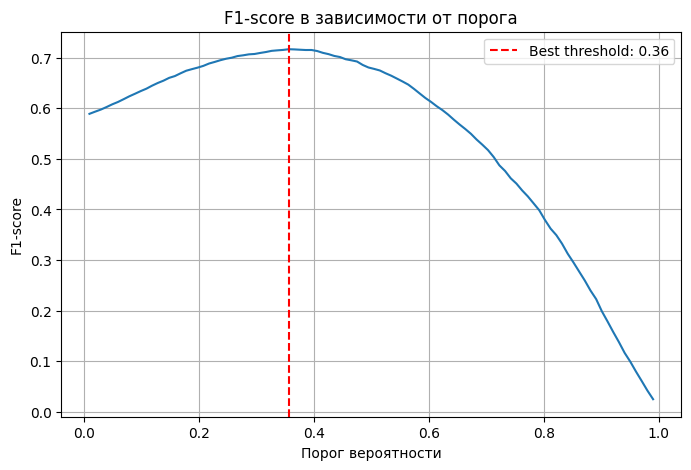

üîé –õ—É—á—à–∏–π –ø–æ—Ä–æ–≥: 0.36
üéØ F1-score –ø—Ä–∏ –Ω—ë–º: 0.717


In [101]:
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = [f1_score(Y_test, (y_proba_nn >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# –ì—Ä–∞—Ñ–∏–∫ F1-score –ø–æ –ø–æ—Ä–æ–≥–∞–º
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores)
plt.xlabel("–ü–æ—Ä–æ–≥ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏")
plt.ylabel("F1-score")
plt.title("F1-score –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –ø–æ—Ä–æ–≥–∞")
plt.grid(True)

# –õ—É—á—à–∏–π –ø–æ—Ä–æ–≥
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
plt.axvline(best_thresh, color='red', linestyle='--', label=f"Best threshold: {best_thresh:.2f}")
plt.legend()
plt.show()



print(f"üîé –õ—É—á—à–∏–π –ø–æ—Ä–æ–≥: {best_thresh:.2f}")
print(f"üéØ F1-score –ø—Ä–∏ –Ω—ë–º: {best_f1:.3f}")

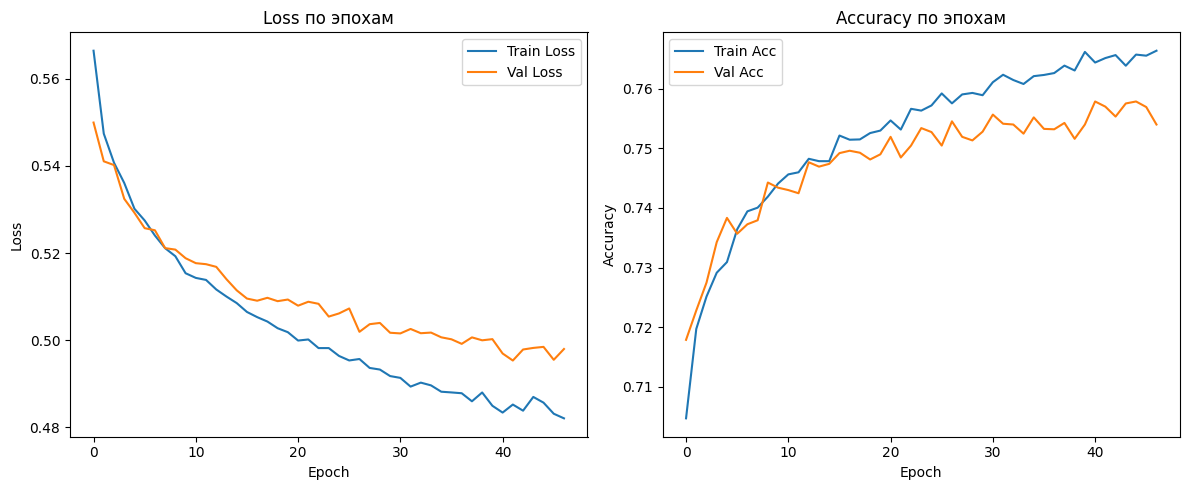

In [103]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss –ø–æ —ç–ø–æ—Ö–∞–º")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy –ø–æ —ç–ø–æ—Ö–∞–º")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

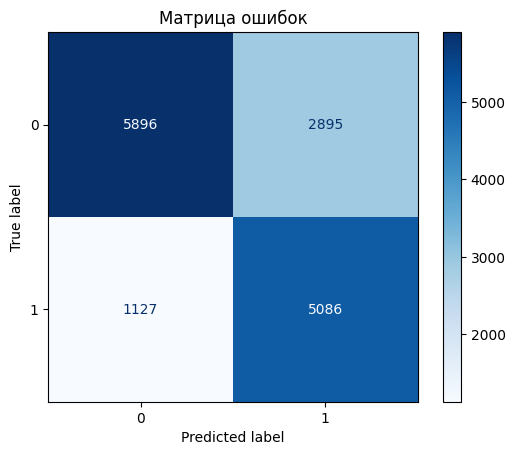

In [104]:
cm = confusion_matrix(Y_test, y_pred_nn)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("–ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫")
plt.show()

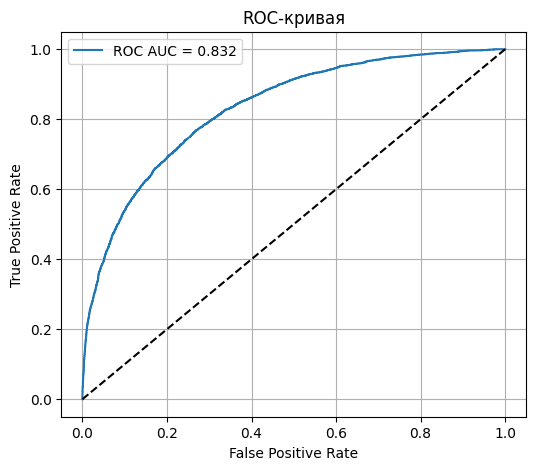

In [105]:
fpr, tpr, _ = roc_curve(Y_test, y_proba_nn)
auc = roc_auc_score(Y_test, y_proba_nn)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-–∫—Ä–∏–≤–∞—è")
plt.legend()
plt.grid()
plt.show()

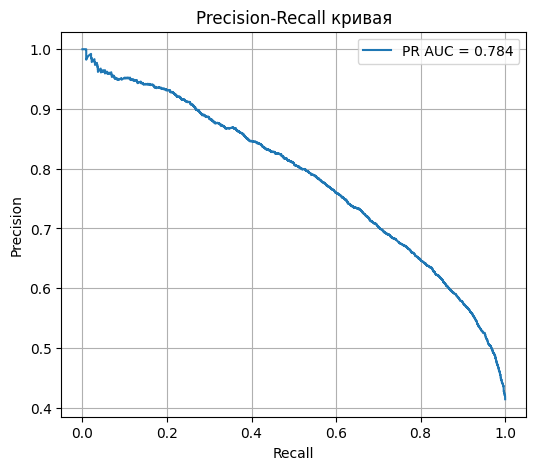

In [106]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, pr_thresholds = precision_recall_curve(Y_test, y_proba_nn)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall –∫—Ä–∏–≤–∞—è")
plt.legend()
plt.grid(True)
plt.show()

–°–¥–µ–ª–∞–µ–º —Ç–∞–±–ª–∏—Ü—É —Å—Ä–∞–≤–Ω–µ–Ω–∏—è

In [108]:
# –ò—Ç–æ–≥–æ–≤–∞—è —Ç–∞–±–ª–∏—Ü–∞ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
comparison = pd.DataFrame([
    {
        "Model": "LogisticRegression_STScaler",
        "F1-score": round(f1_score(Y_test, y_pred_log), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_pred_log ), 3)
    },
    {
        "Model": "LinearSVC",
        "F1-score": round(f1_score(Y_test, y_pred_svm), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_scores_svm ), 3)
    },
    {
        "Model": "LinearSVC c –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤",
        "F1-score": round(f1_score(Y_test, y_pred_svm_gp), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_scores_svm_gp), 3)
    },
    #{
    #  "Model": "SVC",
    #   "F1-score": round(f1_score(Y_test, y_pred_svc), 3),
    #   "ROC AUC": round(roc_auc_score(Y_test, y_proba_svc), 3)
    #},
    {
        "Model": "Random Forest",
        "F1-score": round(f1_score(Y_test, y_pred_rf), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_rf), 3)
    },
    {
        "Model": "Gradient Boosting",
        "F1-score": round(f1_score(Y_test, y_pred_gb), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_gb), 3)
    },
    {
        "Model": "Bagging + LogisticRegression",
        "F1-score": round(f1_score(Y_test, y_pred_bag), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_bag), 3)
    },
    {
        "Model": "ExtraTreesClassifier",
        "F1-score": round(f1_score(Y_test, y_pred_et), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_et), 3)
    },
    {
        "Model": "VotingClassifier (RF + ET + LR)",
        "F1-score": round(f1_score(Y_test, y_pred_voting_rf_et_lr), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_voting_rf_et_lr), 3)
    },
    {
        "Model": "StackingClassifier (RF + ET + LR)",
        "F1-score": round(f1_score(Y_test, y_pred_stack), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_stack), 3)
    },
    {
        "Model": "Neural Network",
        "F1-score": round(f1_score(Y_test, y_pred_nn), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_nn), 3)
    }
])
print (comparison)


                               Model  F1-score  ROC AUC
0        LogisticRegression_STScaler     0.654    0.693
1                          LinearSVC     0.654    0.763
2    LinearSVC c –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤     0.654    0.763
3                      Random Forest     0.771    0.895
4                  Gradient Boosting     0.660    0.800
5       Bagging + LogisticRegression     0.654    0.763
6               ExtraTreesClassifier     0.777    0.898
7    VotingClassifier (RF + ET + LR)     0.772    0.890
8  StackingClassifier (RF + ET + LR)     0.792    0.902
9                     Neural Network     0.717    0.832


–ü–æ—Å—Ç–æ–∏–º –º–∞—Ç—Ä–∏—Ü—É –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –¥–ª—è –º–æ–¥–µ–ª–µ–π —Å –Ω–∏–≤—ã—Å—à–∏–º F1-score

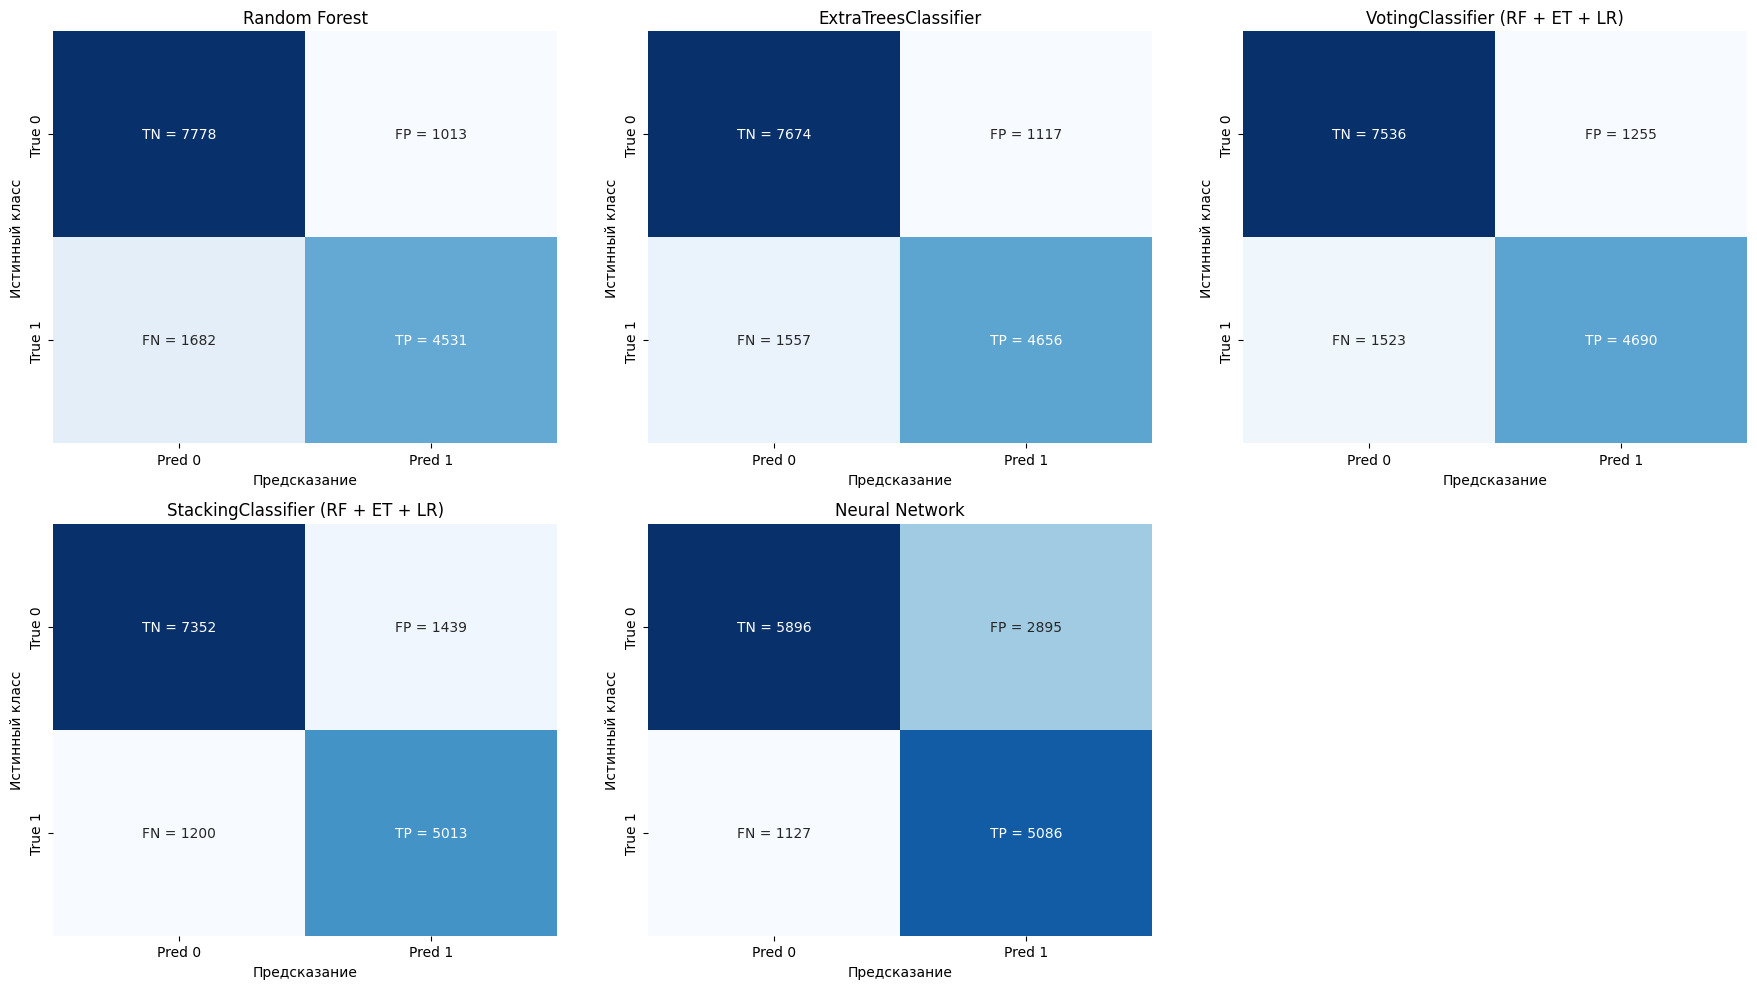

In [109]:
# –°–ª–æ–≤–∞—Ä—å –º–æ–¥–µ–ª–µ–π –∏ –∏—Ö –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
models_preds = {
    "Random Forest": y_pred_rf,
    "ExtraTreesClassifier": y_pred_et,
    "VotingClassifier (RF + ET + LR)": y_pred_voting_rf_et_lr,
    "StackingClassifier (RF + ET + LR)": y_pred_stack,
    "Neural Network": y_pred_nn,
}

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–æ–≤
n = len(models_preds)
cols = 3
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(models_preds.items()):
    cm = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    labels = np.array([
        [f"TN = {tn}", f"FP = {fp}"],
        [f"FN = {fn}", f"TP = {tp}"]
    ])

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'],
                ax=axes[idx])
    
    axes[idx].set_title(f"{name}")
    axes[idx].set_xlabel("–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ")
    axes[idx].set_ylabel("–ò—Å—Ç–∏–Ω–Ω—ã–π –∫–ª–∞—Å—Å")

# –£–¥–∞–ª–∏—Ç—å –ª–∏—à–Ω–∏–µ –ø—É—Å—Ç—ã–µ –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–∏
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.subplots_adjust(wspace=50, hspace=50)

plt.tight_layout()
plt.show()

–ü–æ—Å—Ç—Ä–æ–∏–º –¥–ª—è —ç—Ç–∏—Ö –º–æ–¥–µ–ª–µ–π PR-–∫—Ä–∏–≤—ã–µ, —á—Ç–æ–±—ã –≤–∏–∑—É–∞–ª–∏–∑–∏—Ä–æ–≤–∞—Ç—å, –∫–∞–∫–∞—è –º–æ–¥–µ–ª—å –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –ª—É—á—à–µ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç –ª–∏–¥–µ—Ä–æ–≤

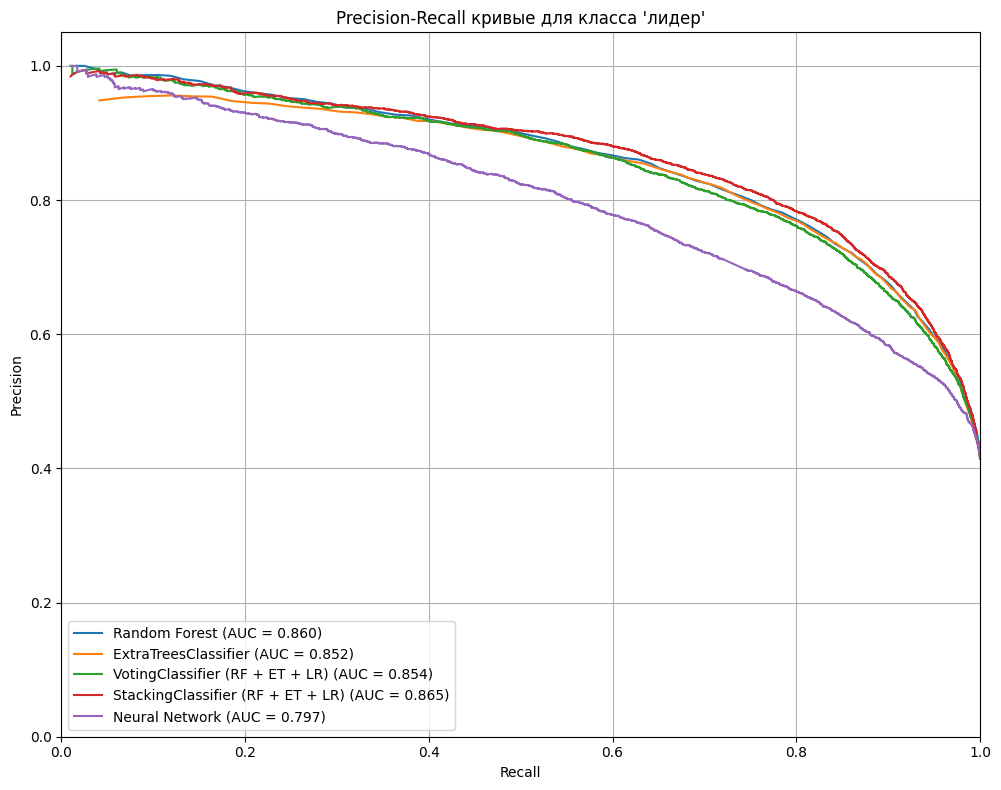

In [98]:
# –ü–æ–ª—É—á–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ –∏ –ø–æ–ª–Ω–æ—Ç—ã –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
prec_rf, rec_rf, _ = precision_recall_curve(Y_test, y_proba_rf)
prec_et, rec_et, _ = precision_recall_curve(Y_test, y_proba_et)
prec_voting, rec_voting, _ = precision_recall_curve(Y_test, y_proba_voting_rf_et_lr)
prec_stack, rec_stack, _ = precision_recall_curve(Y_test, y_proba_stack)
prec_nn, rec_nn, _ = precision_recall_curve(Y_test, y_proba_nn)

# –ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥ –ø–æ recall
min_recall_threshold = 0.01

# –ú–∞—Å–∫–∏
mask_rf = rec_rf > min_recall_threshold
mask_et = rec_et > min_recall_threshold
mask_voting = rec_voting > min_recall_threshold
mask_stack = rec_stack > min_recall_threshold
mask_nn = rec_nn > min_recall_threshold

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ PR-–∫—Ä–∏–≤—ã—Ö
plt.figure(figsize=(10, 8))
plt.plot(rec_rf[mask_rf], prec_rf[mask_rf], label=f"Random Forest (AUC = {auc(rec_rf, prec_rf):.3f})")
plt.plot(rec_et[mask_et], prec_et[mask_et], label=f"ExtraTreesClassifier (AUC = {auc(rec_et, prec_et):.3f})")
plt.plot(rec_voting[mask_voting], prec_voting[mask_voting], label=f"VotingClassifier (RF + ET + LR) (AUC = {auc(rec_voting, prec_voting):.3f})")
plt.plot(rec_stack[mask_stack], prec_stack[mask_stack], label=f"StackingClassifier (RF + ET + LR) (AUC = {auc(rec_stack, prec_stack):.3f})")
plt.plot(rec_nn[mask_nn], prec_nn[mask_nn], label=f"Neural Network (AUC = {auc(rec_nn, prec_nn):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall –∫—Ä–∏–≤—ã–µ –¥–ª—è –∫–ª–∞—Å—Å–∞ '–ª–∏–¥–µ—Ä'")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.show()